In [620]:
import pickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import r2_score
from boruta import BorutaPy
import itertools
from datetime import datetime
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

from scipy.optimize import curve_fit
import math
import lightgbm as lgb
import statsmodels.api as sm

from time import sleep
import ast
from sklearn.model_selection import StratifiedKFold, cross_validate
import graphviz
from sklearn import tree

# Importar registros

In [102]:
baseinit=pd.read_csv('ds_challenge_2021.csv')

In [103]:
# Creacion de variable dia
baseinit['dia']=[datetime.strptime(date, '%m/%d/%Y').day for date in baseinit['fecha']]

In [104]:
baseinit['r_monto_linea'] = baseinit['monto']/baseinit['linea_tc']
baseinit['r_monto_linea'] = baseinit['r_monto_linea'].astype(float)

In [105]:
#Split de la variable dispositivo en device score y os
device_score=[]
os=[]
for cont in range(len(baseinit)):
    device_score.append(ast.literal_eval(baseinit['dispositivo'][cont])['device_score'])
    os.append(ast.literal_eval(baseinit['dispositivo'][cont])['os'])

In [626]:
# Creacion de variables
montoant=[]
ctd_operbyuser=[]
horas_ant=[]
ctd_oper1=[]
ctd_oper0=[]
dif_os=[]
dif_est=[]
baseinit['diahora']=(baseinit['dia']*24)+baseinit['hora']
for cont in range(len(baseinit)):
    id_user=baseinit['ID_USER'][cont]
    diahora=baseinit['diahora'][cont]
    if len(baseinit.loc[(baseinit['ID_USER']==id_user)&
                        (baseinit['diahora']<diahora)].sort_values(by=['diahora'],
                                                                   ascending=False))==0:
        montoant.append(np.nan)
        ctd_operbyuser.append(1)
        horas_ant.append(np.nan)
        ctd_oper1.append(len(baseinit.loc[(baseinit['ID_USER']==id_user)&(baseinit['diahora']<=diahora)&
                                          (baseinit['status_txn']=='Aceptada')]))
        ctd_oper0.append(len(baseinit.loc[(baseinit['ID_USER']==id_user)&(baseinit['diahora']<=diahora)&
                                          (baseinit['status_txn']=='Rechazada')]))
        dif_os.append(1)
        dif_est.append(1)
    else:
        basex=baseinit.loc[(baseinit['ID_USER']==id_user)&
                           (baseinit['diahora']<diahora)].sort_values(by=['diahora'],ascending=False).reset_index()
        montoant.append(basex['monto'][0])
        ctd_operbyuser.append(len(basex)+1)
        horas_ant.append(basex['diahora'][0])
        ctd_oper1.append(len(baseinit.loc[(baseinit['ID_USER']==id_user)&(baseinit['diahora']<=diahora)&
                                          (baseinit['status_txn']=='Aceptada')]))
        ctd_oper0.append(len(baseinit.loc[(baseinit['ID_USER']==id_user)&(baseinit['diahora']<=diahora)&
                                          (baseinit['status_txn']=='Rechazada')]))
        dif_os.append(len(baseinit.loc[(baseinit['ID_USER']==id_user)&(baseinit['diahora']<=diahora)]['os'].unique()))
        dif_est.append(len(baseinit.loc[(baseinit['ID_USER']==id_user)&(baseinit['diahora']<=diahora)]['establecimiento'].unique()))
    #print(cont)

In [110]:
baseinit['montoant']=montoant # Monto de operacion anterior
baseinit['ctd_operbyuser']=ctd_operbyuser #Cantidad de operaciones del usuario
baseinit['horas_ant']=horas_ant # Para calculo
baseinit['ctd_oper1']=ctd_oper1 # Cantidad de operaciones aceptadas
baseinit['ctd_oper0']=ctd_oper0 # Cantidad de operaciones rechazadas
baseinit['dif_os']=dif_os # Diferentes sistemas operativos
baseinit['dif_est']=dif_est # Diferentes establecimientos

In [127]:
baseinit['var_monto']=(baseinit['monto']/baseinit['montoant'])-1 # Variacion del monto respecto a la ultima operacion
baseinit['horas_slo']=(baseinit['diahora']-baseinit['horas_ant']) # Horas transcurridas desde la ultima operacion

In [ ]:
# Seteamos el target como si el cliente tendra fraude en un futuro o si tuvo en algun momento

In [128]:
listado=baseinit.loc[baseinit['fraude']==1]['ID_USER']

In [129]:
baseinit.loc[baseinit['ID_USER'].isin(listado),'fraude2']=True
baseinit.loc[~baseinit['ID_USER'].isin(listado),'fraude2']=False

In [130]:
base=baseinit.copy()

## Datos importantes de la base

In [131]:
print(len(base))
print(base['fraude2'].sum())
print(round(base['fraude2'].sum()/len(base),5))

26975
7792
0.28886


In [140]:
# Dropeo de variables no importantes para el analisis
var_x=list(base.columns)
var_x_1=var_x
var_x_1.remove('ID_USER') # Id
var_x_1.remove('fraude2') # Target
var_x_1.remove('dispositivo') # Se separo
var_x_1.remove('fecha') # Se tiene el dia
var_x_1.remove('fraude') # Target foto
var_x_1.remove('horas_ant') # Ya esta incluida en horas_slo
var_x_1.remove('diahora') #Ya esta incluida

In [141]:
# Categorizacion de variables
continua=[]
catg=[]
disc=[]
for var in var_x_1:
    print(var)
    if len(base[var].unique()) > len(base)*0.01:
        print('continua')
        continua.append(var)
    elif len(base[var].unique()) > 8:
        print('discreta')
        disc.append(var)
    else :
        print('categorica')
        catg.append(var)

genero
categorica
monto
continua
hora
discreta
device_score
categorica
os
categorica
establecimiento
categorica
ciudad
categorica
tipo_tc
categorica
linea_tc
discreta
interes_tc
discreta
status_txn
categorica
is_prime
categorica
dcto
continua
cashback
continua
dia
discreta
r_monto_linea
continua
montoant
continua
ctd_operbyuser
discreta
ctd_oper1
discreta
ctd_oper0
discreta
dif_os
categorica
dif_est
categorica
var_monto
continua
horas_slo
continua


In [142]:
# Categorizacion manual
disc.append('dif_os')
disc.append('dif_est')
#disc.append('dif_ciu')

catg.remove('dif_os')
catg.remove('dif_est')
#catg.remove('dif_ciu')

In [143]:
#Analisis de variables
for varcat in catg:
    print(varcat)
    print(base[varcat].unique())
    print("********************************************")

genero
['F' nan 'M']
********************************************
device_score
[3 1 2 4 5]
********************************************
os
['ANDROID' nan 'WEB' '%%']
********************************************
establecimiento
['Super' nan 'MPago' 'Abarrotes' 'Farmacia' 'Restaurante']
********************************************
ciudad
['Merida' 'Guadalajara' 'Toluca' 'Monterrey' nan]
********************************************
tipo_tc
['fisica' 'Virtual']
********************************************
status_txn
['Aceptada' 'En proceso' 'Rechazada']
********************************************
is_prime
[False  True]
********************************************


# ANALISIS DE VARIABLES CONTINUAS

In [148]:

X_train, X_test, y_train, y_test = train_test_split(base[var_x_1],base['fraude2'],
                                                    test_size=0.3,random_state=1234,stratify=base['fraude2'])
ginis_na=[]
ginis_nona=[]
max_val=[]
min_val=[]
mean_val=[]
P5=[]
P95=[]
miss=[]
for cont in continua+disc:
    #sm.Logit(y_train,X_train[cont]).fit().summary()
    #clf=sm.Logit(y_train,X_train[cont]).fit()
    #gini = 2*metrics.roc_auc_score(y_test, clf.predict(X_test[cont])) -1
    #ginis_na.append(gini*100)
    max_val.append(base[cont].max())
    min_val.append(base[cont].min())
    mean_val.append(base[cont].mean())
    P5.append(np.nanpercentile(base[cont], 5))
    P95.append(np.nanpercentile(base[cont], 95))
    miss.append((len(base.loc[base[cont].isna()==True])/len(base))*100)

for cont in continua+disc:
    newxtrain=X_train.loc[X_train[cont].isna()==False].copy()
    newytrain=y_train.drop(index=X_train.loc[X_train[cont].isna()==True].index)
    newxtest=X_test.loc[X_test[cont].isna()==False].copy()
    newytest=y_test.drop(index=X_test.loc[X_test[cont].isna()==True].index)
    #sm.Logit(newytrain,newxtrain[cont]).fit().summary()
    clf=sm.Logit(newytrain,newxtrain[cont]).fit()
    gini = 2*metrics.roc_auc_score(newytest, clf.predict(newxtest[cont])) -1
    ginis_nona.append(gini*100)

Optimization terminated successfully.
         Current function value: 0.622706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691991
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.615613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604346
  

In [149]:

ginis_na_nl=[]

for cont in continua+disc:
    #sm.Logit(y_train,X_train[cont]).fit().summary()
    newxtrain=X_train.loc[X_train[cont].isna()==False].copy()
    newytrain=y_train.drop(index=X_train.loc[X_train[cont].isna()==True].index)
    newxtest=X_test.loc[X_test[cont].isna()==False].copy()
    newytest=y_test.drop(index=X_test.loc[X_test[cont].isna()==True].index)
    
    tree = DecisionTreeClassifier(random_state = 1234)
    tree.fit(newxtrain[[cont]],newytrain)
    gini = 2*metrics.roc_auc_score(newytest, tree.predict_proba(newxtest[[cont]])[:,1]) -1
    ginis_na_nl.append(gini*100)

In [151]:
# Principales datos de variables numericas
pd.DataFrame(list(zip(continua+disc,ginis_nona,ginis_na_nl,max_val,P95,min_val,P5,mean_val,miss)),
             columns=['Var num','Gini sin nulos','Gini no linear','Max','P95','Min','P5','Mean','% Missing'])

Var num  Gini sin nulos  Gini no linear           Max  \
0            monto       -0.762182       -0.397846    999.920000   
1             dcto        0.477578        0.616141    199.360000   
2         cashback       -1.793092       -1.196743     19.990000   
3    r_monto_linea       -2.660408       -0.346283      0.039858   
4         montoant        0.182258        0.642183    999.920000   
5        var_monto       -0.587795       -0.525585  34106.500000   
6        horas_slo       19.325190       15.427701    647.000000   
7             hora       -0.325391        1.275538     23.000000   
8         linea_tc        4.257666       25.845633  99000.000000   
9       interes_tc        1.307704       12.829339     64.000000   
10             dia       -0.450733        1.018782     30.000000   
11  ctd_operbyuser      -29.724701       29.582555     61.000000   
12       ctd_oper1      -29.818033       29.830534     37.000000   
13       ctd_oper0      -17.679513       17.680731      9.000000   
14          dif_os      -24.674769       24.674769      4.000000   
15         dif_est      -28.288096       28.288096      6.000000   

             P95           Min            P5          Mean  % Missing  
0     948.985000  2.000000e-02     49.531000    499.069472   0.000000  
1      90.412000  0.000000e+00      0.000000     17.466124   0.000000  
2      16.000000  0.000000e+00      0.560000      6.261209   0.000000  
3       0.023638  7.142857e-07      0.000790      0.009288   0.000000  
4     949.592500  2.000000e-02     49.465000    499.529522  14.898981  
5       9.060506 -9.999165e-01     -0.896389      4.960015  14.898981  
6     242.000000  1.000000e+00      3.000000     69.916928  14.898981  
7      22.000000  1.000000e+00      2.000000     11.987618   0.000000  
8   96000.000000  2.500000e+04  28000.000000  62476.811863   0.000000  
9      63.000000  3.200000e+01     33.000000     48.224875   0.000000  
10     29.000000  2.000000e+00      3.000000     16.043855   0.000000  
11     19.000000  1.000000e+00      1.000000      6.697201   0.000000  
12     14.000000  0.000000e+00      0.000000      4.688675   0.000000  
13      3.000000  0.000000e+00      0.000000      0.705468   0.000000  
14      4.000000  1.000000e+00      1.000000      2.760371   0.000000  
15      6.000000  1.000000e+00      1.000000      3.253197   0.000000

In [152]:
desc_num=pd.DataFrame(list(zip(continua+disc,ginis_nona,ginis_na_nl,max_val,P95,min_val,P5,mean_val,miss)),
             columns=['Var num','Gini sin nulos','Gini no linear','Max','P95','Min','P5','Mean','% Missing'])

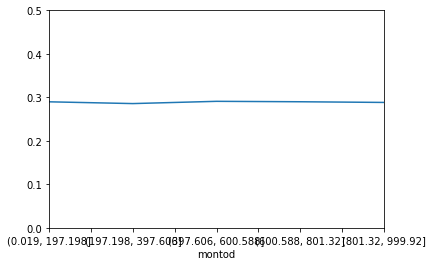

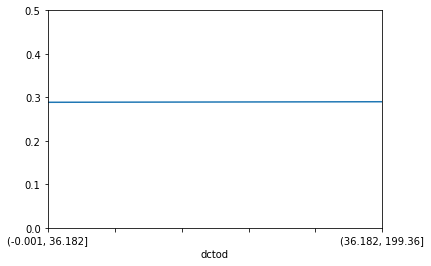

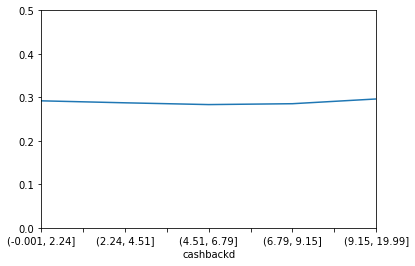

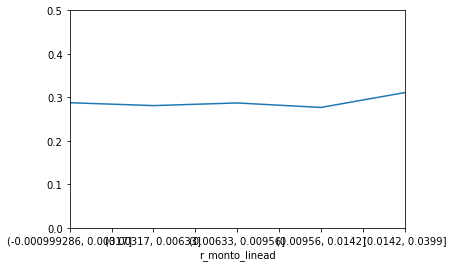

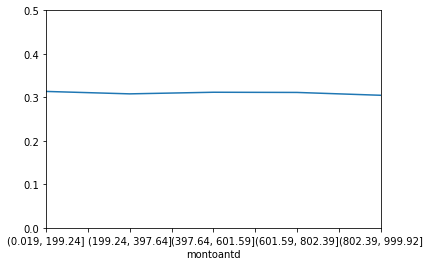

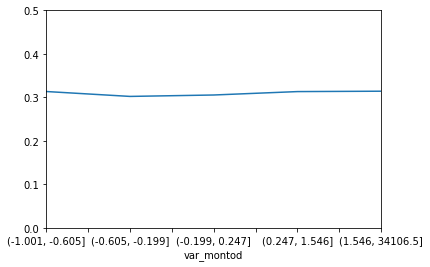

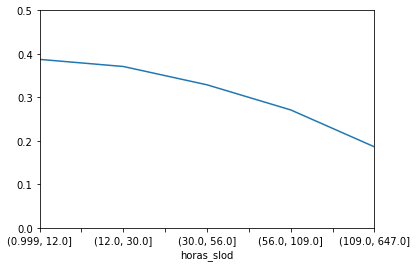

In [153]:
# Graficos bivariados de variables continuas

for ix in range(len(continua)):
    base_r=base.copy()
    base_r[continua[ix]+'d']=pd.qcut(base_r[continua[ix]], q=5,duplicates='drop')
    base_rx=base_r.groupby([continua[ix]+'d'],sort=True)['fraude2'].mean()
    plt.figure()
    base_rx.plot(kind='line',ylim=[0,0.5])
    plt.show()

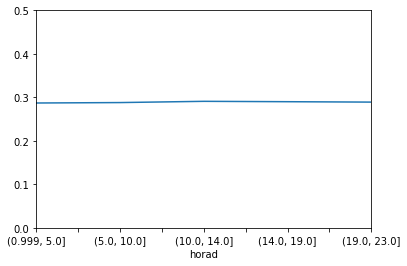

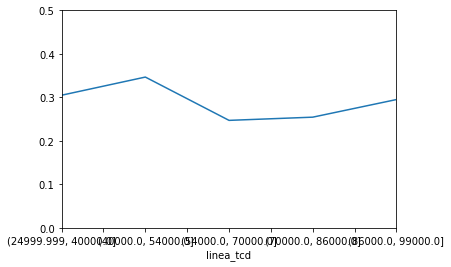

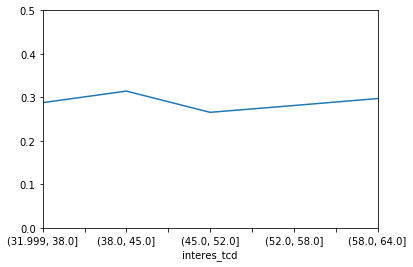

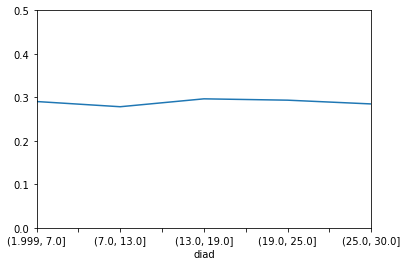

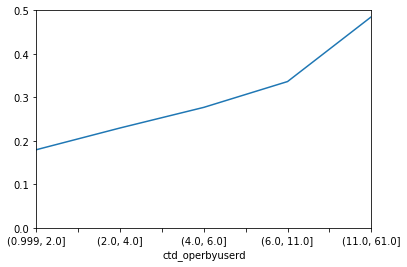

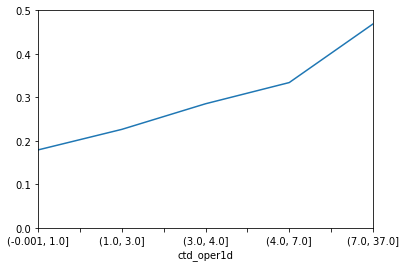

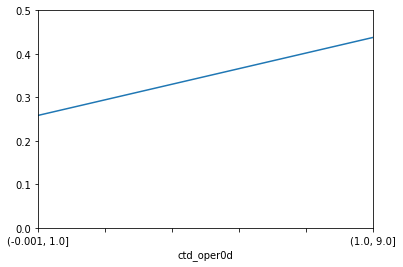

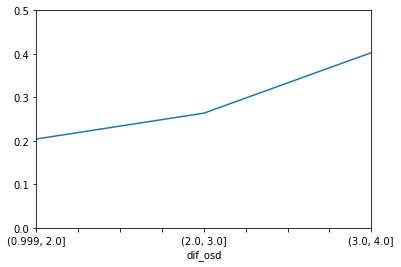

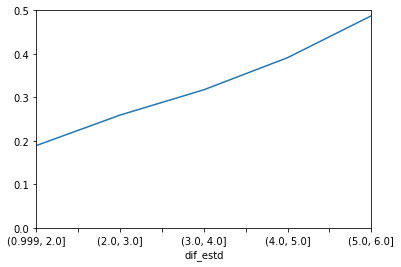

In [154]:
# Graficos bivariados de variables discretas

for ix in range(len(disc)):
    base_r=base.copy()
    base_r[disc[ix]+'d']=pd.qcut(base_r[disc[ix]], q=5,duplicates='drop')
    base_rx=base_r.groupby([disc[ix]+'d'],sort=True)['fraude2'].mean()
    plt.figure()
    base_rx.plot(kind='line',ylim=[0,0.5])
    plt.show()

# Analisis variables categoricas

In [155]:
ginis_na=[]
ctd_cat=[]
miss=[]
for cat in catg:
    newxtraincat=pd.get_dummies(X_train[cat])
    newxtestcat=pd.get_dummies(X_test[cat])
    clf=sm.Logit(y_train,newxtraincat).fit()
    gini = 2*metrics.roc_auc_score(y_test, clf.predict(newxtestcat)) -1
    ginis_na.append(gini*100)
    ctd_cat.append(len(newxtraincat.columns))
    miss.append((len(base.loc[base[cat].isna()==True])/len(base))*100)

Optimization terminated successfully.
         Current function value: 0.610557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600932
         Iterations 5


In [156]:
ginis_nona=[]
for cat in catg:
    newxtrain=X_train.loc[X_train[cat].isna()==False].copy()
    newytrain=y_train.drop(index=X_train.loc[X_train[cat].isna()==True].index)
    newxtest=X_test.loc[X_test[cat].isna()==False].copy()
    newytest=y_test.drop(index=X_test.loc[X_test[cat].isna()==True].index)
    
    newxtraincat=pd.get_dummies(newxtrain[cat])
    newxtestcat=pd.get_dummies(newxtest[cat])
    clf=sm.Logit(newytrain,newxtraincat).fit()
    gini = 2*metrics.roc_auc_score(newytest, clf.predict(newxtestcat)) -1
    ginis_nona.append(gini*100)

Optimization terminated successfully.
         Current function value: 0.601202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600932
         Iterations 5


In [157]:
pd.DataFrame(list(zip(catg,ginis_na,ginis_nona,ctd_cat,miss)),
             columns=['Var cat','Gini','Gini sin nulos','Ctd categor','% Missing'])

Var cat      Gini  Gini sin nulos  Ctd categor  % Missing
0           genero  3.219189        3.366584            2  10.120482
1     device_score -1.736118       -1.736118            5   0.000000
2               os -0.067431       -0.183043            3  24.893420
3  establecimiento  0.617405        2.810625            5  37.512512
4           ciudad  0.768878        1.720207            4  43.291937
5          tipo_tc  1.643648        1.643648            2   0.000000
6       status_txn  2.472957        2.472957            3   0.000000
7         is_prime  1.525248        1.525248            2   0.000000

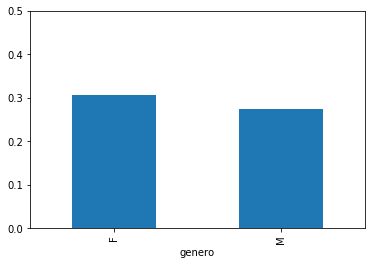

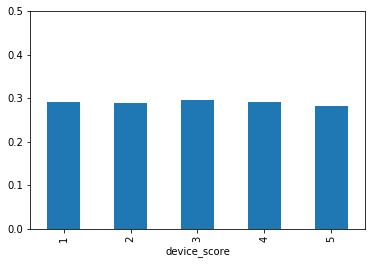

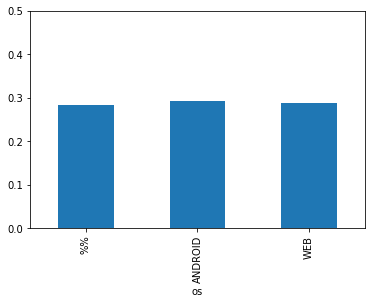

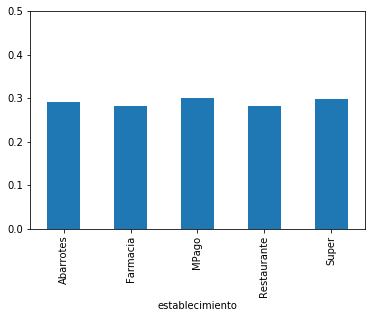

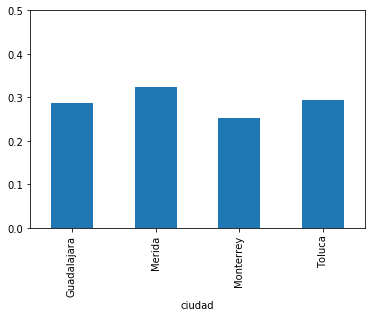

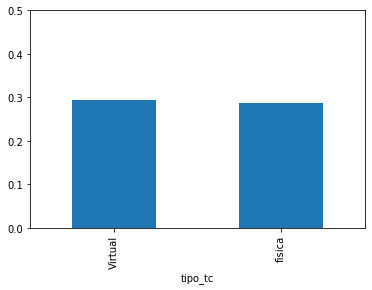

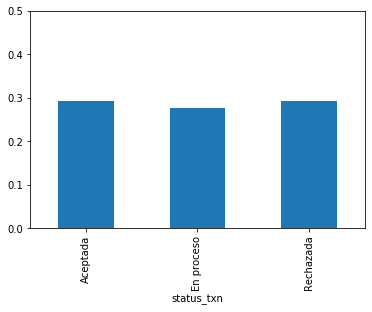

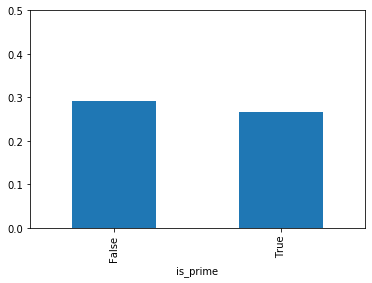

In [158]:
for ix in range(len(catg)):
    base_r=base.loc[base[catg[ix]].isna()==False]
    base_rx=base_r.groupby([catg[ix]],sort=True)['fraude2'].mean()
    plt.figure()
    base_rx.plot(kind='bar',ylim=[0,0.5])
    plt.show()

# Separacion en train test

In [159]:
ids_target=base[['ID_USER','fraude2']].drop_duplicates(subset=['ID_USER','fraude2']).sort_values(by=['ID_USER'])
ids_target['idtarget']=ids_target['ID_USER'].astype(str)+ids_target['fraude2'].astype(str)

In [160]:
idtrain, idtest,bor,bor = train_test_split(ids_target,ids_target['fraude2'],test_size=0.30,random_state=123,
                                           stratify=ids_target['fraude2'])

In [161]:
print("rf train: " +str(idtrain['fraude2'].mean()))
print("rf test: " +str(idtest['fraude2'].mean()))

rf train: 0.16892857142857143
rf test: 0.16833333333333333


In [162]:
base['idtarget']=base['ID_USER'].astype(str)+base['fraude2'].astype(str)
train_byidtarget=base.loc[base['idtarget'].isin(idtrain['idtarget'])].reset_index()
test_byidtarget=base.loc[base['idtarget'].isin(idtest['idtarget'])].reset_index()

In [163]:
print("rf train: " +str(train_byidtarget['fraude2'].mean()))
print("rf test: " +str(test_byidtarget['fraude2'].mean()))

rf train: 0.2924418604651163
rf test: 0.28044692737430166


# Acotamiento de variables numericas (outliers)

In [164]:
# Cotas
COTAS=pd.DataFrame()
for i,j in  zip(continua+disc, range(len(train_byidtarget))):
    per5=np.percentile(train_byidtarget[i].dropna(),5)
    per95=np.percentile(train_byidtarget[i].dropna(),95)
    COTAS.loc[j,'VARIABLE']=i
    COTAS.loc[j,'PER5']=per5
    COTAS.loc[j,'PER95']=per95
COTAS.to_csv('COTAS.csv',index=False)

In [165]:
COTAS=pd.read_csv("COTAS.csv",sep=',', encoding ='latin1')
def acotamiento(dfr):
    for i in range(len(COTAS)):
        VAR   = COTAS.loc[i,'VARIABLE']
        PER5  = COTAS.loc[i,'PER5']
        PER95 = COTAS.loc[i,'PER95']
        dfr[VAR+'_acot'] = dfr[VAR].apply(lambda x: PER5 if x < PER5 else 
                                        PER95 if x > PER95 else 
                                        x)                               
    return dfr
    
train_byidtarget_v2 = acotamiento(train_byidtarget)
test_byidtarget_v2 = acotamiento(test_byidtarget)

In [166]:
numericas=continua+disc
numericas_2=[s + '_acot' for s in numericas]

In [167]:
numericas_3=[]
for col in numericas_2:
    bor = train_byidtarget_v2[col]
    bor2 = bor.unique()
    if np.isnan(bor2).any()==True:
        if len(bor2)>2:
            numericas_3.append(col)
    else:
        if len(bor2)>1:
            numericas_3.append(col)

# Correlacion

In [168]:
corr_mtx = train_byidtarget_v2[numericas_3].corr().abs()

In [169]:
grupos_saved=[]
grupos_discard=[]
for var in numericas_3:
    if var not in grupos_discard:
        grupos_saved.append(list(corr_mtx.loc[corr_mtx[var]>0.7].index))
        grupos_discard.extend(list(corr_mtx.loc[corr_mtx[var]>0.7].index))

In [170]:
#Eleccion de mejores variables

In [171]:
desc_num['Var num']=[s + '_acot' for s in desc_num['Var num']]

In [176]:
grupos_saved

[['monto_acot', 'cashback_acot', 'r_monto_linea_acot'],
 ['dcto_acot'],
 ['montoant_acot'],
 ['var_monto_acot'],
 ['horas_slo_acot'],
 ['hora_acot'],
 ['linea_tc_acot'],
 ['interes_tc_acot'],
 ['dia_acot'],
 ['ctd_operbyuser_acot', 'ctd_oper1_acot', 'dif_os_acot', 'dif_est_acot'],
 ['ctd_oper0_acot']]

In [173]:
desc_num.loc[desc_num['Var num'].isin(grupos_saved[0])] #r_monto_linea_acot

Var num  Gini sin nulos  Gini no linear         Max         P95  \
0          monto_acot       -0.762182       -0.397846  999.920000  948.985000   
2       cashback_acot       -1.793092       -1.196743   19.990000   16.000000   
3  r_monto_linea_acot       -2.660408       -0.346283    0.039858    0.023638   

            Min        P5        Mean  % Missing  
0  2.000000e-02  49.53100  499.069472        0.0  
2  0.000000e+00   0.56000    6.261209        0.0  
3  7.142857e-07   0.00079    0.009288        0.0

In [178]:
desc_num.loc[desc_num['Var num'].isin(grupos_saved[9])] #ctd_operbyuser_acot

Var num  Gini sin nulos  Gini no linear   Max   P95  Min   P5  \
11  ctd_operbyuser_acot      -29.724701       29.582555  61.0  19.0  1.0  1.0   
12       ctd_oper1_acot      -29.818033       29.830534  37.0  14.0  0.0  0.0   
14          dif_os_acot      -24.674769       24.674769   4.0   4.0  1.0  1.0   
15         dif_est_acot      -28.288096       28.288096   6.0   6.0  1.0  1.0   

        Mean  % Missing  
11  6.697201        0.0  
12  4.688675        0.0  
14  2.760371        0.0  
15  3.253197        0.0

In [179]:
numericas_4=['r_monto_linea_acot','montoant_acot','var_monto_acot','dia_acot','horas_slo_acot',
               'dcto_acot','hora_acot','ctd_operbyuser_acot','linea_tc_acot',
               'interes_tc_acot','ctd_oper0_acot']

# Transformaciones numericas

In [180]:
def TRANSFORMATION_A1(data,var,ruta):
    x=data[var]
    y=data['TARGET']
    #Tranforación Polinomial de 1 Grado
    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, x, y)
    # summarize the parameter values
    a, b = popt
    # print('y = %.5f'%a +'*'+str(var)+'+ %.5f' % b)
    # plot input vs output
    y_line = objective(x, a, b)
    print(r2_score(y_line,y))
    name=str(var)+'_A1.png'
    # create a line plot for the mapping function
    fig, ax1 = plt.subplots()
    kwargs = dict(alpha=0.5, bins=100, histtype='bar')  
    ax1.hist(np.array(x),**kwargs)
    ax1.set_ylabel('Dist.'+ str(var))
    ax1.set_xlabel(var)
    ax2 = ax1.twinx()
    ax2.plot(np.array(x), np.array(y_line), '--', color='red', label=u'Transformation')
    ax2.scatter(x, y, label=u'Scatter plot')
    plt.title('Transformation Pol 1° '+ str(var))
    ax2.set_ylabel('Ratio de fraude2')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(ruta + name) 
    plt.show()
    return a, b, r2_score(y_line,y)

In [181]:
def TRANSFORMATION_A2(data,var,ruta):
    x=data[var]
    y=data['TARGET']
    #Tranforación Polinomial de 1 Grado
    def objective(x, a, b, c):
        return a * (x**2) + b*x +c
    popt, _ = curve_fit(objective, x, y)
    # summarize the parameter values
    a, b, c = popt
    # print('y = %.5f'%a +'*'+str(var)+'+ %.5f' % b)
    # plot input vs output
    y_line = objective(x, a, b, c)
    print(r2_score(y_line,y))
    name=str(var)+'_A2.png'
    # create a line plot for the mapping function
    fig, ax1 = plt.subplots()
    kwargs = dict(alpha=0.5, bins=100, histtype='bar')  
    ax1.hist(np.array(x),**kwargs)
    ax1.set_ylabel('Dist.'+ str(var))
    ax1.set_xlabel(var)
    ax2 = ax1.twinx()
    ax2.plot(np.array(x), np.array(y_line), '--', color='red', label=u'Transformation')
    ax2.scatter(x, y, label=u'Scatter plot')
    plt.title('Transformation Pol 2° '+ str(var))
    ax2.set_ylabel('Ratio de fraude2')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(ruta + name) 
    plt.show()
    return a, b, c, r2_score(y_line,y)

-3.046771055264742


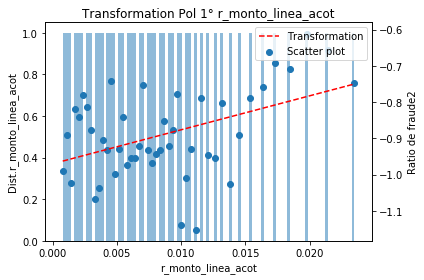

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


-84.8847575887802


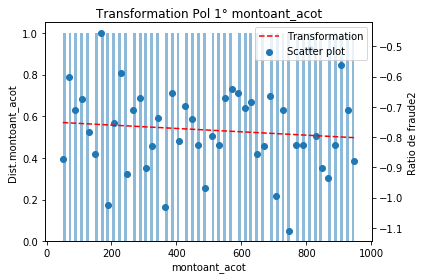

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


-1575.9234195268698


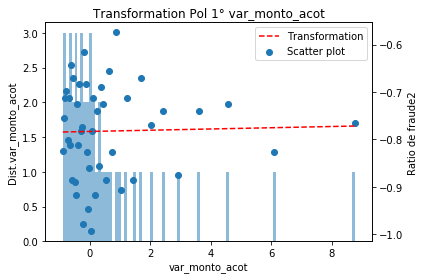

-203.09625412593985


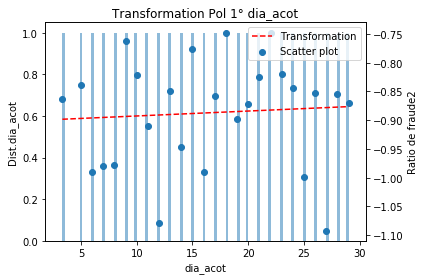

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.8978048481686993


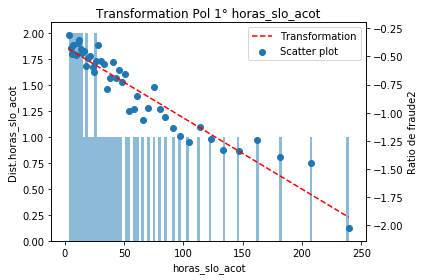

-610.3348119964493


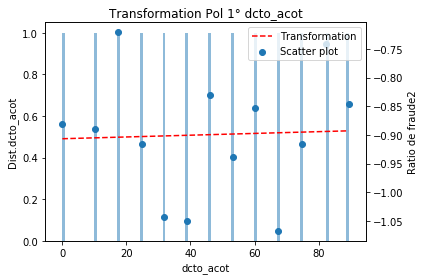

-25.980259242465596


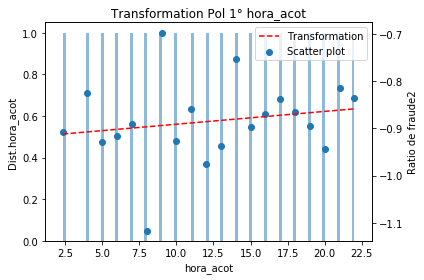

0.9838914064972554


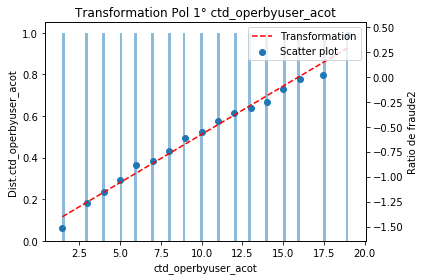

-14.352189425151474


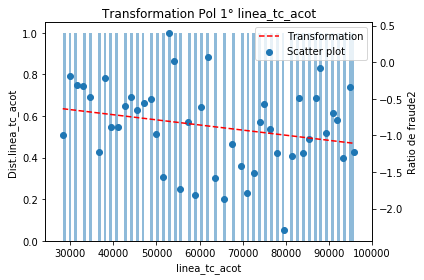

-54.22792171288951


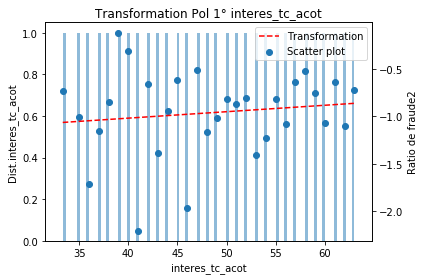

0.9690307045657176


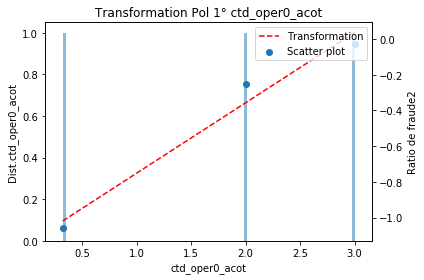

In [182]:
EQUATION_A1=pd.DataFrame()
borrar_1=train_byidtarget_v2.copy()
for i, j in zip(numericas_4, range(len(numericas_4))):
    borrar=borrar_1.loc[borrar_1[i].isna()==False]
    borrar[i +str('_bins')] = pd.qcut(x=borrar[i], q=50,duplicates='drop')
    group2=borrar.groupby([i +str('_bins')],sort=True)[[i,'fraude2']].mean().reset_index()
    group2['fraude2']=np.log(group2['fraude2']/(1-group2['fraude2']))
    group2.columns=[i +str('_var_bins'),i,'TARGET']
    group2
    a, b, r2 =TRANSFORMATION_A1(group2,i,'plots/')
    #Tranformacion lineal
    EQUATION_A1.loc[j,'VARIABLE']=i
    EQUATION_A1.loc[j,'a']=a
    EQUATION_A1.loc[j,'b']=b
    EQUATION_A1.loc[j,'r2']=r2
EQUATION_A1.to_csv('EQUATION_A1.csv',index=False)

-1.0644197022372905


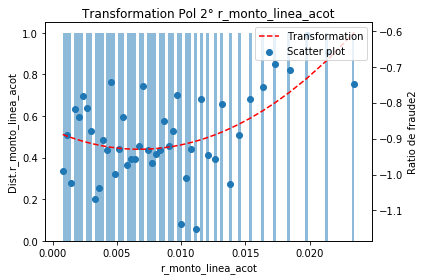

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


-62.57450019716263


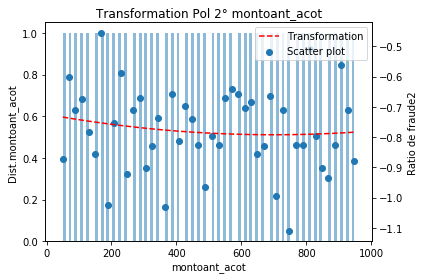

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


-1572.4123558384074


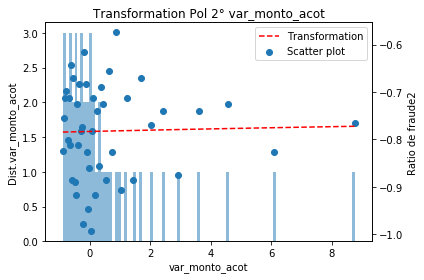

-32.23244013953343


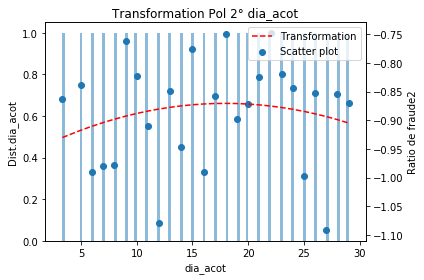

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.9139509948766099


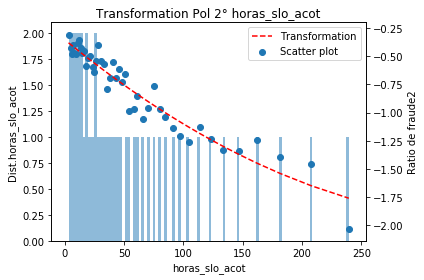

-3.762389316709278


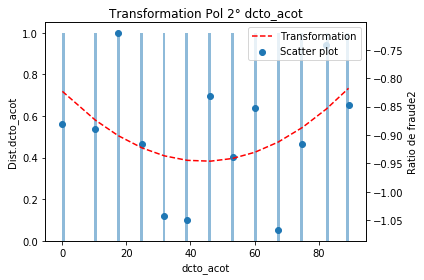

-23.019537829133192


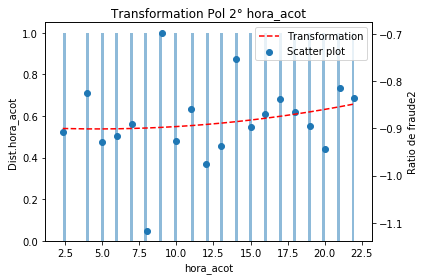

0.9849815455752696


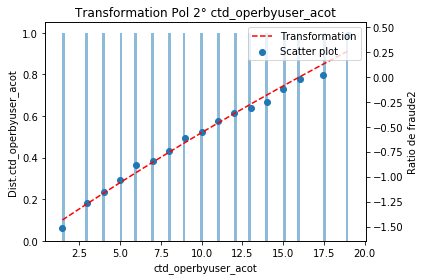

-5.744542815337921


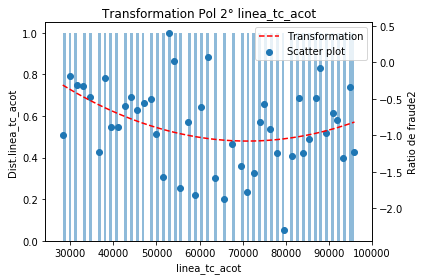

-31.938773612523782


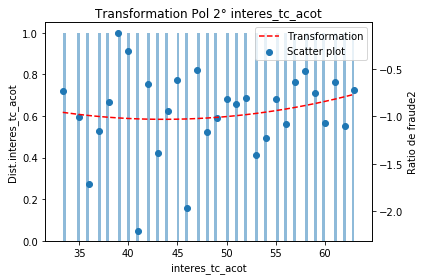

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.0


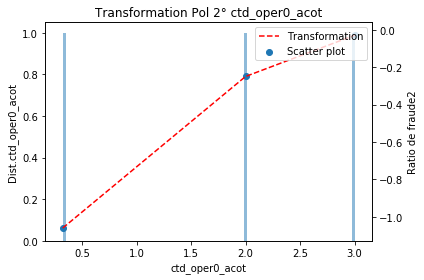

In [183]:
EQUATION_A2=pd.DataFrame()
borrar_1=train_byidtarget_v2.copy()
for i, j in zip(numericas_4, range(len(numericas_4))):
    borrar=borrar_1.loc[borrar_1[i].isna()==False]
    borrar[i +str('_bins')] = pd.qcut(x=borrar[i], q=50,duplicates='drop')
    group2=borrar.groupby([i +str('_bins')],sort=True)[[i,'fraude2']].mean().reset_index()
    group2['fraude2']=np.log(group2['fraude2']/(1-group2['fraude2']))
    group2.columns=[i +str('_var_bins'),i,'TARGET']
    group2
    a, b, c, r2 =TRANSFORMATION_A2(group2,i,'plots/')
    print
    #Tranformacion lineal
    EQUATION_A2.loc[j,'VARIABLE']=i
    EQUATION_A2.loc[j,'a']=a
    EQUATION_A2.loc[j,'b']=b
    EQUATION_A2.loc[j,'c']=c
    EQUATION_A2.loc[j,'r2']=r2
EQUATION_A2.to_csv('EQUATION_A2.csv',index=False)

In [184]:
EQUATION_A1=pd.read_csv("EQUATION_A1.csv",sep=',', encoding ='latin1')
EQUATION_A2=pd.read_csv("EQUATION_A2.csv",sep=',', encoding ='latin1')

In [185]:
EQUATION_A1[['VARIABLE','r2']]

VARIABLE           r2
0    r_monto_linea_acot    -3.046771
1         montoant_acot   -84.884758
2        var_monto_acot -1575.923420
3              dia_acot  -203.096254
4        horas_slo_acot     0.897805
5             dcto_acot  -610.334812
6             hora_acot   -25.980259
7   ctd_operbyuser_acot     0.983891
8         linea_tc_acot   -14.352189
9       interes_tc_acot   -54.227922
10       ctd_oper0_acot     0.969031

In [186]:
EQUATION_A2[['VARIABLE','r2']]

VARIABLE           r2
0    r_monto_linea_acot    -1.064420
1         montoant_acot   -62.574500
2        var_monto_acot -1572.412356
3              dia_acot   -32.232440
4        horas_slo_acot     0.913951
5             dcto_acot    -3.762389
6             hora_acot   -23.019538
7   ctd_operbyuser_acot     0.984982
8         linea_tc_acot    -5.744543
9       interes_tc_acot   -31.938774
10       ctd_oper0_acot     1.000000

In [187]:
def objective_A1(x, a, b):
    return a * x + b
def objective_A2(x, a, b, c):
    return a * (x**2) + b*x +c

In [188]:
for i in range(len(EQUATION_A1)):
    train_byidtarget_v2[str(EQUATION_A1.iloc[i,0])+'_A1']=objective_A1(train_byidtarget_v2[EQUATION_A1.iloc[i,0]],EQUATION_A1.iloc[i,1],EQUATION_A1.iloc[i,2])
    test_byidtarget_v2[str(EQUATION_A1.iloc[i,0])+'_A1']=objective_A1(test_byidtarget_v2[EQUATION_A1.iloc[i,0]],EQUATION_A1.iloc[i,1],EQUATION_A1.iloc[i,2])

In [189]:
for i in range(len(EQUATION_A2)):
    train_byidtarget_v2[str(EQUATION_A2.iloc[i,0])+'_A2']=objective_A2(train_byidtarget_v2[EQUATION_A2.iloc[i,0]],EQUATION_A2.iloc[i,1],EQUATION_A2.iloc[i,2],EQUATION_A2.iloc[i,3])
    test_byidtarget_v2[str(EQUATION_A2.iloc[i,0])+'_A2']=objective_A2(test_byidtarget_v2[EQUATION_A2.iloc[i,0]],EQUATION_A2.iloc[i,1],EQUATION_A2.iloc[i,2],EQUATION_A2.iloc[i,3])

In [190]:
numericas_5=['r_monto_linea_acot_A2','montoant_acot_A1','var_monto_acot_A1','dia_acot_A2',
             'horas_slo_acot_A1','dcto_acot_A2','hora_acot_A1','ctd_operbyuser_acot_A1',
             'linea_tc_acot_A1','interes_tc_acot_A1','ctd_oper0_acot_A1']

## Missing numericas

In [191]:
missing_input=[]
for rep in numericas_5:
    if len(train_byidtarget_v2.loc[train_byidtarget_v2[rep].isna()==True])==0:
        imput_val=train_byidtarget_v2['fraude2'].mean()
        imput_val2=np.log(imput_val/(1-imput_val))
        missing_input.append(imput_val2)
    else:
        imput_val=train_byidtarget_v2.loc[train_byidtarget_v2[rep].isna()==True]['fraude2'].mean()
        imput_val2=np.log(imput_val/(1-imput_val))
        missing_input.append(imput_val2)

In [192]:
MISSING_VALUES=pd.DataFrame(list(zip(numericas_5,missing_input)),columns=['VARIABLE','MISSING_VAL'])
MISSING_VALUES.to_csv('missing_values.csv',index=False)

In [193]:
missing_input=[]
for rep in catg:
    if len(train_byidtarget_v2.loc[train_byidtarget_v2[rep].isna()==True])==0:
        imput_val=train_byidtarget_v2['fraude2'].mean()
        imput_val2=np.log(imput_val/(1-imput_val))
        missing_input.append(imput_val2)
    else:
        imput_val=train_byidtarget_v2.loc[train_byidtarget_v2[rep].isna()==True]['fraude2'].mean()
        imput_val2=np.log(imput_val/(1-imput_val))
        missing_input.append(imput_val2)

In [194]:
MISSING_VALUESCAT=pd.DataFrame(list(zip(catg,missing_input)),columns=['VARIABLE','MISSING_VAL'])
MISSING_VALUESCAT.to_csv('missing_valuescat.csv',index=False)

# Transformacion categoricas

In [195]:
categories=[]
for i in range(len(catg)):
    values=list(train_byidtarget_v2.loc[train_byidtarget_v2[catg[i]].isna()==False][catg[i]].unique())
    cattransf=[]
    for val in values:
        imput_val=train_byidtarget_v2.loc[train_byidtarget_v2[catg[i]]==val]['fraude2'].mean()
        imput_val2=np.log(imput_val/(1-imput_val))
        cattransf.append([val,imput_val2])
    categories.append(cattransf)

In [634]:
categories[0]

[['F', -0.8028964989252048], ['M', -0.9813220337835374]]

In [196]:
for i in range(len(catg)):
    values=list(train_byidtarget_v2.loc[train_byidtarget_v2[catg[i]].isna()==False][catg[i]].unique())
    for j in range(len(values)):
        train_byidtarget_v2.loc[train_byidtarget_v2[catg[i]]==values[j],catg[i]+'_st']=categories[i][j][1]
        test_byidtarget_v2.loc[test_byidtarget_v2[catg[i]]==values[j],catg[i]+'_st']=categories[i][j][1]

## Missing categoricas

In [198]:
for i in range(len(catg)):
    train_byidtarget_v2.loc[train_byidtarget_v2[catg[i]].isna()==True,catg[i]+'_st']=MISSING_VALUESCAT['MISSING_VAL'][i]
    test_byidtarget_v2.loc[test_byidtarget_v2[catg[i]].isna()==True,catg[i]+'_st']=MISSING_VALUESCAT['MISSING_VAL'][i]
for i in range(len(numericas_5)):
    train_byidtarget_v2.loc[train_byidtarget_v2[numericas_5[i]].isna()==True,numericas_5[i]]=MISSING_VALUES['MISSING_VAL'][i]
    test_byidtarget_v2.loc[test_byidtarget_v2[numericas_5[i]].isna()==True,numericas_5[i]]=MISSING_VALUES['MISSING_VAL'][i]

In [199]:
catg_1=[s + '_st' for s in catg]

# Seleccion de variables

In [200]:
y2= train_byidtarget_v2['fraude2']
data2= train_byidtarget_v2[numericas_5+catg_1]

In [201]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [202]:
from sklearn.ensemble import RandomForestClassifier

In [203]:
# Seleccion por boruta
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', max_depth=5,criterion='gini')
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(data2.values, y2)
timer(start_time)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	8

 Time taken: 0 hours 0 minutes and 3.74 seconds.


In [205]:
pd.DataFrame(list(zip(numericas_5+catg_1,boruta_selector.support_)),
             columns=['Var','Selected']).sort_values(by=['Selected'],ascending=False)

Var  Selected
0    r_monto_linea_acot_A2      True
7   ctd_operbyuser_acot_A1      True
15               ciudad_st      True
11               genero_st      True
10       ctd_oper0_acot_A1      True
1         montoant_acot_A1      True
8         linea_tc_acot_A1      True
9       interes_tc_acot_A1      True
4        horas_slo_acot_A1      True
3              dia_acot_A2      True
2        var_monto_acot_A1      True
6             hora_acot_A1     False
5             dcto_acot_A2     False
12         device_score_st     False
13                   os_st     False
14      establecimiento_st     False
16              tipo_tc_st     False
17           status_txn_st     False
18             is_prime_st     False

In [206]:
selection_var=pd.DataFrame(list(zip(numericas_5+catg_1,boruta_selector.support_)),
             columns=['Var','Selected']).sort_values(by=['Selected'],ascending=False)
var_finales=list(selection_var.loc[selection_var['Selected']==True]['Var'])

In [524]:
# Metodo descartado, se utilizo porque el boruta no encontraba variables importantes, por ende se introdujo un forzaje
"""
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# define feature selection
fs = SelectKBest(score_func=f_classif, k=10)
# apply feature selection
X_selected = fs.fit(data2, y2)

#pd.DataFrame(list(zip(numericas_5+catg_1,X_selected.get_support())),
#             columns=['Var','Selected']).sort_values(by=['Selected'],ascending=False)
"""

"""selection_var=pd.DataFrame(list(zip(numericas_5+catg_1,X_selected.get_support())),
             columns=['Var','Selected']).sort_values(by=['Selected'],ascending=False)
var_finales=list(selection_var.loc[selection_var['Selected']==True]['Var'])"""

"selection_var=pd.DataFrame(list(zip(numericas_5+catg_1,X_selected.get_support())),\n             columns=['Var','Selected']).sort_values(by=['Selected'],ascending=False)\nvar_finales=list(selection_var.loc[selection_var['Selected']==True]['Var'])"

# Modelamiento

## Modelos lineales

Prueba lineal con una regresion logistica y una pequeña grilla

In [208]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
model = LogisticRegression(random_state= 123, solver='lbfgs', max_iter=5000,penalty='l2')

grid = {"C": [0.001, 0.01,0.1,0.5,1],
       'class_weight': ['balanced',{True:0.5,False:0.5}]}

gs = GridSearchCV(model, param_grid = grid, cv = kfold, return_train_score=True, scoring = 'recall',verbose = 2)
gs.fit(train_byidtarget_v2[var_finales],train_byidtarget_v2['fraude2'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.001, class_weight={True: 0.5, False: 0.5}, total=   0.0s
[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.00

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .... C=0.001, class_weight={True: 0.5, False: 0.5}, total=   0.0s
[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.001, class_weight={True: 0.5, False: 0.5}, total=   0.0s
[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.001, class_weight={True: 0.5, False: 0.5}, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=5000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'class_weight': ['balanced', {False: 0.5, True: 0.5}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=2)

In [209]:
gs.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [210]:
#gini train
probs = gs.best_estimator_.predict_proba(train_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(train_byidtarget_v2['fraude2'], probs[:,1])-1
gini

0.3522874244648033

In [211]:
#gini test
probs = gs.best_estimator_.predict_proba(test_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(test_byidtarget_v2['fraude2'], probs[:,1])-1
gini

0.27807472662833854

## MODELOS NO LINEALES

### Decision tree

Prueba con un arbol de decisiones para conocer el performance

In [212]:
model = DecisionTreeClassifier(random_state = 123)
max_depth=5
min_sample_split=24
min_sample_leaf=6
grid = {"max_depth": [max_depth-1, max_depth, max_depth+1],
        "max_features": ['auto', 'log2'],
        "min_samples_split": [min_sample_split-2, min_sample_split, min_sample_split+2],
        "min_samples_leaf": [min_sample_leaf],
        "criterion": ["gini", 'entropy'],
        'class_weight': ['balanced',None],
        'max_features': [0.6,0.8,1]
        }
gs = GridSearchCV(model, param_grid = grid, cv = kfold, n_jobs=-1, return_train_score=True, scoring = 'roc_auc',verbose=2)
gs.fit(train_byidtarget_v2[var_finales],train_byidtarget_v2['fraude2'])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    5.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
       

In [213]:
gs.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
                       max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=22,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [214]:
pd.DataFrame(list(zip(numericas_5+catg_1,gs.best_estimator_.feature_importances_)),
             columns=['Var','Importance']).sort_values(by=['Importance'],ascending=False)

Var  Importance
1         montoant_acot_A1    0.432392
6             hora_acot_A1    0.152522
8         linea_tc_acot_A1    0.127912
7   ctd_operbyuser_acot_A1    0.096640
9       interes_tc_acot_A1    0.056290
3              dia_acot_A2    0.050839
2        var_monto_acot_A1    0.031363
4        horas_slo_acot_A1    0.029832
10       ctd_oper0_acot_A1    0.013866
0    r_monto_linea_acot_A2    0.008343
5             dcto_acot_A2    0.000000

In [215]:
#gini train
probs = gs.best_estimator_.predict_proba(train_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(train_byidtarget_v2['fraude2'], probs[:,1])-1
gini

0.4329739795335703

In [216]:
#gini test
probs = gs.best_estimator_.predict_proba(test_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(test_byidtarget_v2['fraude2'], probs[:,1])-1
gini

0.26902282748463224

### Lightgbm

Prueba con un modelo de machine learning para conocer el performance

In [217]:
ids_target2=train_byidtarget_v2[['ID_USER','fraude2']].drop_duplicates(subset=['ID_USER','fraude2']).sort_values(by=['ID_USER'])
ids_target2['idtarget']=ids_target2['ID_USER'].astype(str)+ids_target2['fraude2'].astype(str)

In [527]:
# spliteo al train en watch list para el refuerzo

In [218]:
idtrain2, idtest2,bor,bor = train_test_split(ids_target2,ids_target2['fraude2'],test_size=0.20,random_state=123,
                                           stratify=ids_target2['fraude2'])

In [219]:
print("rf train: " +str(idtrain2['fraude2'].mean()))
print("rf test: " +str(idtest2['fraude2'].mean()))

rf train: 0.16875
rf test: 0.16964285714285715


In [220]:
train=train_byidtarget_v2.loc[train_byidtarget_v2['idtarget'].isin(idtrain2['idtarget'])].reset_index()
watch=train_byidtarget_v2.loc[train_byidtarget_v2['idtarget'].isin(idtest2['idtarget'])].reset_index()

In [221]:
print("len train: " +str(train['fraude2'].count()))
print("len watch: " +str(watch['fraude2'].count()))

len train: 15097
len watch: 3823


In [222]:
print("rf train: " +str(train['fraude2'].mean()))
print("rf test: " +str(watch['fraude2'].mean()))

rf train: 0.29403192687288865
rf test: 0.28616269945069317


In [223]:
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 123)
model = lgb.LGBMClassifier(num_boost_round=500,verbose_eval="False",random_state=123,
                           metric='auc',eval_metric='auc')
max_depth=3
num_leaves=64
learning_rate=0.1
max_bin=128
bagging=0.8
grid = {'boosting_type': ['gbdt'],
        'objective': ['binary'],
        'max_depth':[max_depth+1,max_depth],
        'num_leaves':[num_leaves],
        'learning_rate': [learning_rate],
        #'min_child_samples': [min_child], #1740 un 3% del total de los datos
        #'min_child_weight': [100],
        'lambda_l2':[0,0.3],
        'is_unbalance':['true'],
        'max_bin':[max_bin],
        'bagging_fraction':[bagging]
        }
gs = GridSearchCV(model, param_grid = grid, cv = kfold, refit = 'auc', n_jobs=-1, return_train_score=True)

gs.fit(train[var_finales],train['fraude2'],eval_set=[(watch[var_finales],watch['fraude2'])],
       early_stopping_rounds=200,eval_metric='auc',verbose=True)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[1]	valid_0's auc: 0.633505
[2]	valid_0's auc: 0.646977
[3]	valid_0's auc: 0.645912
[4]	valid_0's auc: 0.650534
[5]	valid_0's auc: 0.653616
[6]	valid_0's auc: 0.651993
[7]	valid_0's auc: 0.65183
[8]	valid_0's auc: 0.649702
[9]	valid_0's auc: 0.651877
[10]	valid_0's auc: 0.652899
[11]	valid_0's auc: 0.654207
[12]	valid_0's auc: 0.65281
[13]	valid_0's auc: 0.654977
[14]	valid_0's auc: 0.653745
[15]	valid_0's auc: 0.652508
[16]	valid_0's auc: 0.652991
[17]	valid_0's auc: 0.650216
[18]	valid_0's auc: 0.650099
[19]	valid_0's auc: 0.651563
[20]	valid_0's 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0, eval_metric='auc',
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      metric='auc', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimato...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0, verbose_eval='False'),
             iid='warn', n_jobs=-1,
             param_grid={'bagging_fraction': [0.8], 'boosting_type': ['gbdt'],
                         'is_unbalance': ['true'], 'lambda_l2': [0, 0.3],
                         'lear

In [224]:
probs = gs.best_estimator_.predict_proba(train[var_finales])
gini = 2*metrics.roc_auc_score(train['fraude2'], probs[:,1])-1
gini

0.5964466045873356

In [225]:
probs = gs.best_estimator_.predict_proba(watch[var_finales])
gini = 2*metrics.roc_auc_score(watch['fraude2'], probs[:,1])-1
gini

0.3185864065494657

In [226]:
probs = gs.best_estimator_.predict_proba(test_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(test_byidtarget_v2['fraude2'], probs[:,1])-1
gini

0.2832482660417299

# Seleccion del modelo final

In [227]:
max_depth=[2,3,4,5,6,7] 
min_sample_split=[4,8,12,24,36] 
min_sample_leaf=[4,8,12,24,36]
class_weight=[None] # Se quito el metodo 'balanced', debido a que la distribucion ya no es tan distante
max_features=[1,0.8,0.5]

In [228]:
fs_results = pd.DataFrame(columns = ['max_depth', 'min_sample_split', 'min_sample_leaf','class_weight','max_features'])
for md,mss,msl,cw,mf in itertools.product(max_depth, min_sample_split,min_sample_leaf,class_weight,max_features):
    row = {'max_depth':md, 'min_sample_split':mss,'min_sample_leaf':msl,'class_weight':cw,'max_features':mf}
    fs_results = fs_results.append(row, ignore_index=True)
del md,mss,msl,cw,mf

In [229]:
fs_results

max_depth  min_sample_split  min_sample_leaf  class_weight  max_features
0          2.0               4.0              4.0           NaN           1.0
1          2.0               4.0              4.0           NaN           0.8
2          2.0               4.0              4.0           NaN           0.5
3          2.0               4.0              8.0           NaN           1.0
4          2.0               4.0              8.0           NaN           0.8
..         ...               ...              ...           ...           ...
445        7.0              36.0             24.0           NaN           0.8
446        7.0              36.0             24.0           NaN           0.5
447        7.0              36.0             36.0           NaN           1.0
448        7.0              36.0             36.0           NaN           0.8
449        7.0              36.0             36.0           NaN           0.5

[450 rows x 5 columns]

In [230]:
fs_results['max_depth']=fs_results['max_depth'].astype(int)
fs_results['min_sample_split']=fs_results['min_sample_split'].astype(int)
fs_results['min_sample_leaf']=fs_results['min_sample_leaf'].astype(int)
fs_results['max_features']=fs_results['max_features'].astype(float)

In [232]:
gini_train=[]
gini_test=[]
gini_total=[]
for cont in range(len(fs_results)):
    if type(fs_results['class_weight'][cont])==np.float64:
        model = DecisionTreeClassifier(random_state = 123)
        grid = {"max_depth": [fs_results['max_depth'][cont]],
                "max_features": ['auto', 'log2'],
                "min_samples_split": [fs_results['min_sample_split'][cont]],
                "min_samples_leaf": [fs_results['min_sample_leaf'][cont]],
                "criterion": ["gini", 'entropy'],
                'class_weight': [None],
                'max_features': [fs_results['max_features'][cont]]
                }
        gs = GridSearchCV(model, param_grid = grid, cv = kfold, n_jobs=-1, return_train_score=True, scoring = 'roc_auc',verbose=2)
        gs.fit(train_byidtarget_v2[var_finales],train_byidtarget_v2['fraude2'])
        probs = gs.best_estimator_.predict_proba(train_byidtarget_v2[var_finales])
        gini = 2*metrics.roc_auc_score(train_byidtarget_v2['fraude2'], probs[:,1])-1
        gini_train.append(gini)
        probs = gs.best_estimator_.predict_proba(test_byidtarget_v2[var_finales])
        gini = 2*metrics.roc_auc_score(test_byidtarget_v2['fraude2'], probs[:,1])-1
        gini_test.append(gini)
        print(cont)
        total_byidtarget_v2 = pd.concat([train_byidtarget_v2,test_byidtarget_v2])
        probs = gs.best_estimator_.predict_proba(total_byidtarget_v2[var_finales])
        gini = 2*metrics.roc_auc_score(total_byidtarget_v2['fraude2'], probs[:,1])-1
        gini_total.append(gini)
    else:
        model = DecisionTreeClassifier(random_state = 123)
        grid = {"max_depth": [fs_results['max_depth'][cont]],
                "max_features": ['auto', 'log2'],
                "min_samples_split": [fs_results['min_sample_split'][cont]],
                "min_samples_leaf": [fs_results['min_sample_leaf'][cont]],
                "criterion": ["gini", 'entropy'],
                'class_weight': [fs_results['class_weight'][cont]],
                'max_features': [fs_results['max_features'][cont]]
                }
        gs = GridSearchCV(model, param_grid = grid, cv = kfold, n_jobs=-1, return_train_score=True, scoring = 'roc_auc',verbose=2)
        gs.fit(train_byidtarget_v2[var_finales],train_byidtarget_v2['fraude2'])
        probs = gs.best_estimator_.predict_proba(train_byidtarget_v2[var_finales])
        gini = 2*metrics.roc_auc_score(train_byidtarget_v2['fraude2'], probs[:,1])-1
        gini_train.append(gini)
        probs = gs.best_estimator_.predict_proba(test_byidtarget_v2[var_finales])
        gini = 2*metrics.roc_auc_score(test_byidtarget_v2['fraude2'], probs[:,1])-1
        gini_test.append(gini)
        print(cont)
        total_byidtarget_v2 = pd.concat([train_byidtarget_v2,test_byidtarget_v2])
        probs = gs.best_estimator_.predict_proba(total_byidtarget_v2[var_finales])
        gini = 2*metrics.roc_auc_score(total_byidtarget_v2['fraude2'], probs[:,1])-1
        gini_total.append(gini)      
fs_results['gini_train']=gini_train
fs_results['gini_test']=gini_test
fs_results['gini_total']=gini_total

Fitting 3 folds for each of 2 candidates, totalling 6 fits
0
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


1
Fitting 3 folds for each of 2 candidates, totalling 6 fits
2
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


3
Fitting 3 folds for each of 2 candidates, totalling 6 fits
4
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


5
Fitting 3 folds for each of 2 candidates, totalling 6 fits
6
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


7
Fitting 3 folds for each of 2 candidates, totalling 6 fits
8
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


9
Fitting 3 folds for each of 2 candidates, totalling 6 fits
10
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


11
Fitting 3 folds for each of 2 candidates, totalling 6 fits
12
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


13
Fitting 3 folds for each of 2 candidates, totalling 6 fits
14
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


15
Fitting 3 folds for each of 2 candidates, totalling 6 fits
16
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


17
Fitting 3 folds for each of 2 candidates, totalling 6 fits
18
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



19
Fitting 3 folds for each of 2 candidates, totalling 6 fits
20

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
21
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


22
Fitting 3 folds for each of 2 candidates, totalling 6 fits
23
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


24
Fitting 3 folds for each of 2 candidates, totalling 6 fits
25
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


26
Fitting 3 folds for each of 2 candidates, totalling 6 fits
27
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


28
Fitting 3 folds for each of 2 candidates, totalling 6 fits
29
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


30
Fitting 3 folds for each of 2 candidates, totalling 6 fits
31
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


32
Fitting 3 folds for each of 2 candidates, totalling 6 fits
33
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


34
Fitting 3 folds for each of 2 candidates, totalling 6 fits
35
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


36
Fitting 3 folds for each of 2 candidates, totalling 6 fits
37
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


38
Fitting 3 folds for each of 2 candidates, totalling 6 fits
39
Fitting 3 folds for each of 2 candidates, totalling 6 fits
40
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


41
Fitting 3 folds for each of 2 candidates, totalling 6 fits
42
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


43
Fitting 3 folds for each of 2 candidates, totalling 6 fits
44
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


45
Fitting 3 folds for each of 2 candidates, totalling 6 fits
46
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



47
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


48
Fitting 3 folds for each of 2 candidates, totalling 6 fits
49
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



50
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


51
Fitting 3 folds for each of 2 candidates, totalling 6 fits
52
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



53
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


54
Fitting 3 folds for each of 2 candidates, totalling 6 fits
55
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


56
Fitting 3 folds for each of 2 candidates, totalling 6 fits
57
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


58
Fitting 3 folds for each of 2 candidates, totalling 6 fits
59
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


60
Fitting 3 folds for each of 2 candidates, totalling 6 fits
61
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


62
Fitting 3 folds for each of 2 candidates, totalling 6 fits
63
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



64
Fitting 3 folds for each of 2 candidates, totalling 6 fits
65

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
66
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



67
Fitting 3 folds for each of 2 candidates, totalling 6 fits
68

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
69
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


70
Fitting 3 folds for each of 2 candidates, totalling 6 fits
71
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


72
Fitting 3 folds for each of 2 candidates, totalling 6 fits
73
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


74
Fitting 3 folds for each of 2 candidates, totalling 6 fits
75


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
76
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


77
Fitting 3 folds for each of 2 candidates, totalling 6 fits
78
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



79
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


80
Fitting 3 folds for each of 2 candidates, totalling 6 fits
81
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



82
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


83
Fitting 3 folds for each of 2 candidates, totalling 6 fits
84


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
85
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


86
Fitting 3 folds for each of 2 candidates, totalling 6 fits
87
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



88
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


89
Fitting 3 folds for each of 2 candidates, totalling 6 fits
90
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


91
Fitting 3 folds for each of 2 candidates, totalling 6 fits
92
Fitting 3 folds for each of 2 candidates, totalling 6 fits
93
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


94
Fitting 3 folds for each of 2 candidates, totalling 6 fits
95
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


96
Fitting 3 folds for each of 2 candidates, totalling 6 fits
97
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



98
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


99
Fitting 3 folds for each of 2 candidates, totalling 6 fits
100
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



101
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


102
Fitting 3 folds for each of 2 candidates, totalling 6 fits
103
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



104
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


105
Fitting 3 folds for each of 2 candidates, totalling 6 fits
106
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


107
Fitting 3 folds for each of 2 candidates, totalling 6 fits
108


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
109
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


110
Fitting 3 folds for each of 2 candidates, totalling 6 fits
111
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



112
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


113
Fitting 3 folds for each of 2 candidates, totalling 6 fits
114


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
115
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


116
Fitting 3 folds for each of 2 candidates, totalling 6 fits
117


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
118
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


119
Fitting 3 folds for each of 2 candidates, totalling 6 fits
120


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
121
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


122
Fitting 3 folds for each of 2 candidates, totalling 6 fits
123
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



124
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


125
Fitting 3 folds for each of 2 candidates, totalling 6 fits
126


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
127
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


128
Fitting 3 folds for each of 2 candidates, totalling 6 fits
129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
130
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


131
Fitting 3 folds for each of 2 candidates, totalling 6 fits
132
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


133
Fitting 3 folds for each of 2 candidates, totalling 6 fits
134
Fitting 3 folds for each of 2 candidates, totalling 6 fits
135
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


136
Fitting 3 folds for each of 2 candidates, totalling 6 fits
137
Fitting 3 folds for each of 2 candidates, totalling 6 fits
138
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


139
Fitting 3 folds for each of 2 candidates, totalling 6 fits
140
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


141
Fitting 3 folds for each of 2 candidates, totalling 6 fits
142
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



143
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


144
Fitting 3 folds for each of 2 candidates, totalling 6 fits
145
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


146
Fitting 3 folds for each of 2 candidates, totalling 6 fits
147
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



148
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


149
Fitting 3 folds for each of 2 candidates, totalling 6 fits
150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
151
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


152
Fitting 3 folds for each of 2 candidates, totalling 6 fits
153
Fitting 3 folds for each of 2 candidates, totalling 6 fits
154
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


155
Fitting 3 folds for each of 2 candidates, totalling 6 fits
156
Fitting 3 folds for each of 2 candidates, totalling 6 fits
157
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


158
Fitting 3 folds for each of 2 candidates, totalling 6 fits
159
Fitting 3 folds for each of 2 candidates, totalling 6 fits
160
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


161
Fitting 3 folds for each of 2 candidates, totalling 6 fits
162
Fitting 3 folds for each of 2 candidates, totalling 6 fits
163
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


164
Fitting 3 folds for each of 2 candidates, totalling 6 fits
165
Fitting 3 folds for each of 2 candidates, totalling 6 fits
166
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


167
Fitting 3 folds for each of 2 candidates, totalling 6 fits
168

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
169
Fitting 3 folds for each of 2 candidates, totalling 6 fits
170
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


171
Fitting 3 folds for each of 2 candidates, totalling 6 fits
172
Fitting 3 folds for each of 2 candidates, totalling 6 fits
173
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


174
Fitting 3 folds for each of 2 candidates, totalling 6 fits
175


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
176
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


177
Fitting 3 folds for each of 2 candidates, totalling 6 fits
178
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



179
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


180
Fitting 3 folds for each of 2 candidates, totalling 6 fits
181


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
182
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


183
Fitting 3 folds for each of 2 candidates, totalling 6 fits
184
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



185
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


186
Fitting 3 folds for each of 2 candidates, totalling 6 fits
187
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



188
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


189
Fitting 3 folds for each of 2 candidates, totalling 6 fits
190
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



191
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


192
Fitting 3 folds for each of 2 candidates, totalling 6 fits
193

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
194
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


195
Fitting 3 folds for each of 2 candidates, totalling 6 fits
196


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
197
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


198
Fitting 3 folds for each of 2 candidates, totalling 6 fits
199


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
200
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


201
Fitting 3 folds for each of 2 candidates, totalling 6 fits
202
Fitting 3 folds for each of 2 candidates, totalling 6 fits
203
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


204
Fitting 3 folds for each of 2 candidates, totalling 6 fits
205


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
206
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


207
Fitting 3 folds for each of 2 candidates, totalling 6 fits
208
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



209
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


210
Fitting 3 folds for each of 2 candidates, totalling 6 fits
211
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



212
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


213
Fitting 3 folds for each of 2 candidates, totalling 6 fits
214

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
215


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
216
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


217
Fitting 3 folds for each of 2 candidates, totalling 6 fits
218
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



219
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



220
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


221
Fitting 3 folds for each of 2 candidates, totalling 6 fits
222


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
223
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


224
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


225
Fitting 3 folds for each of 2 candidates, totalling 6 fits
226


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
227
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


228
Fitting 3 folds for each of 2 candidates, totalling 6 fits
229


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
230
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


231
Fitting 3 folds for each of 2 candidates, totalling 6 fits
232
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



233
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


234
Fitting 3 folds for each of 2 candidates, totalling 6 fits
235

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
236


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
237
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



238
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


239
Fitting 3 folds for each of 2 candidates, totalling 6 fits
240


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
241
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


242
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


243
Fitting 3 folds for each of 2 candidates, totalling 6 fits
244


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
245
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


246
Fitting 3 folds for each of 2 candidates, totalling 6 fits
247


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
248
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


249
Fitting 3 folds for each of 2 candidates, totalling 6 fits
250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
251
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


252
Fitting 3 folds for each of 2 candidates, totalling 6 fits
253

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
254
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



255
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


256
Fitting 3 folds for each of 2 candidates, totalling 6 fits
257
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


258
Fitting 3 folds for each of 2 candidates, totalling 6 fits
259

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
260
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


261
Fitting 3 folds for each of 2 candidates, totalling 6 fits
262
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



263
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


264
Fitting 3 folds for each of 2 candidates, totalling 6 fits
265


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
266
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


267
Fitting 3 folds for each of 2 candidates, totalling 6 fits
268


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
269
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


270
Fitting 3 folds for each of 2 candidates, totalling 6 fits
271
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



272
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


273
Fitting 3 folds for each of 2 candidates, totalling 6 fits
274


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
275
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


276
Fitting 3 folds for each of 2 candidates, totalling 6 fits
277


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
278
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


279
Fitting 3 folds for each of 2 candidates, totalling 6 fits
280


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
281
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


282
Fitting 3 folds for each of 2 candidates, totalling 6 fits
283

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
284
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



285


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
286
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



287
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


288
Fitting 3 folds for each of 2 candidates, totalling 6 fits
289

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
290
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



291
Fitting 3 folds for each of 2 candidates, totalling 6 fits
292
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



293
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


294
Fitting 3 folds for each of 2 candidates, totalling 6 fits
295

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
296


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
297


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
298
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


299
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


300
Fitting 3 folds for each of 2 candidates, totalling 6 fits
301

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
302


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
303


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
304
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


305
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


306
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


307
Fitting 3 folds for each of 2 candidates, totalling 6 fits
308
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


309
Fitting 3 folds for each of 2 candidates, totalling 6 fits
310

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
311


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
312


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
313

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
314


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
315


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
316


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
317
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


318
Fitting 3 folds for each of 2 candidates, totalling 6 fits
319

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
320
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


321
Fitting 3 folds for each of 2 candidates, totalling 6 fits
322

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
323


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
324

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
325


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
326

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


327
Fitting 3 folds for each of 2 candidates, totalling 6 fits
328

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
329
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



330


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
331
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



332
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


333
Fitting 3 folds for each of 2 candidates, totalling 6 fits
334

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
335
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



336

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
337


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
338
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


339
Fitting 3 folds for each of 2 candidates, totalling 6 fits
340


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
341
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


342
Fitting 3 folds for each of 2 candidates, totalling 6 fits
343


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
344
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


345
Fitting 3 folds for each of 2 candidates, totalling 6 fits
346

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
347


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
348


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
349
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



350
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



351


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
352
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


353
Fitting 3 folds for each of 2 candidates, totalling 6 fits
354

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
355


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
356
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


357
Fitting 3 folds for each of 2 candidates, totalling 6 fits
358

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
359
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



360

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
361


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
362
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


363
Fitting 3 folds for each of 2 candidates, totalling 6 fits
364

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
365


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
366

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
367


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
368
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


369
Fitting 3 folds for each of 2 candidates, totalling 6 fits
370

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
371
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


372
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


373
Fitting 3 folds for each of 2 candidates, totalling 6 fits
374
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


375
Fitting 3 folds for each of 2 candidates, totalling 6 fits
376

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
377

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


378
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


379
Fitting 3 folds for each of 2 candidates, totalling 6 fits
380
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



381

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


382
Fitting 3 folds for each of 2 candidates, totalling 6 fits
383
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



384

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


385
Fitting 3 folds for each of 2 candidates, totalling 6 fits
386

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


387
Fitting 3 folds for each of 2 candidates, totalling 6 fits
388


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
389
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


390
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


391
Fitting 3 folds for each of 2 candidates, totalling 6 fits
392


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
393

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


394
Fitting 3 folds for each of 2 candidates, totalling 6 fits
395
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



396

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


397
Fitting 3 folds for each of 2 candidates, totalling 6 fits
398
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



399

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
400

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
401

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


402
Fitting 3 folds for each of 2 candidates, totalling 6 fits
403

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
404


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
405

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


406
Fitting 3 folds for each of 2 candidates, totalling 6 fits
407
Fitting 3 folds for each of 2 candidates, totalling 6 fits

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



408

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


409
Fitting 3 folds for each of 2 candidates, totalling 6 fits
410


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
411

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


412
Fitting 3 folds for each of 2 candidates, totalling 6 fits
413


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
414

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
415

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
416

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


417
Fitting 3 folds for each of 2 candidates, totalling 6 fits
418

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
419


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
420

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
421

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
422


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
423

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
424


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
425
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


426
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


427
Fitting 3 folds for each of 2 candidates, totalling 6 fits
428


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


429
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


430
Fitting 3 folds for each of 2 candidates, totalling 6 fits
431


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
432

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
433

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
434


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
435

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


436
Fitting 3 folds for each of 2 candidates, totalling 6 fits
437


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 2 candidates, totalling 6 fits
438

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
439

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
440
Fitting 3 folds for each of 2 candidates, totalling 6 fits
441

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
442

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
443


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
444

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
445

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s



Fitting 3 folds for each of 2 candidates, totalling 6 fits
446


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
447

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 3 folds for each of 2 candidates, totalling 6 fits
448

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished



Fitting 3 folds for each of 2 candidates, totalling 6 fits
449


In [ ]:
# Decido quedarme con el modelo que mejor performance en test tenga, debido a que se que es el que mejor extrapolara en el futuro

In [233]:
fs_results.sort_values(by=['gini_test','gini_total','gini_train'],ascending=False)

max_depth  min_sample_split  min_sample_leaf  class_weight  max_features  \
150          4                 4                4           NaN           1.0   
153          4                 4                8           NaN           1.0   
156          4                 4               12           NaN           1.0   
159          4                 4               24           NaN           1.0   
162          4                 4               36           NaN           1.0   
..         ...               ...              ...           ...           ...   
62           2                36                4           NaN           0.5   
65           2                36                8           NaN           0.5   
68           2                36               12           NaN           0.5   
71           2                36               24           NaN           0.5   
74           2                36               36           NaN           0.5   

     gini_train  gini_test  gini_total  
150    0.361496   0.295135    0.342203  
153    0.361496   0.295135    0.342203  
156    0.361496   0.295135    0.342203  
159    0.361496   0.295135    0.342203  
162    0.361496   0.295135    0.342203  
..          ...        ...         ...  
62     0.128936   0.090114    0.117892  
65     0.128936   0.090114    0.117892  
68     0.128936   0.090114    0.117892  
71     0.128936   0.090114    0.117892  
74     0.128936   0.090114    0.117892  

[450 rows x 8 columns]

In [234]:
if type(fs_results['class_weight'][150])==np.float64:
    model = DecisionTreeClassifier(random_state = 123)
    grid = {"max_depth": [fs_results['max_depth'][150]],
            "max_features": ['auto', 'log2'],
            "min_samples_split": [fs_results['min_sample_split'][150]],
            "min_samples_leaf": [fs_results['min_sample_leaf'][150]],
            "criterion": ["gini", 'entropy'],
            'class_weight': [None],
            'max_features': [fs_results['max_features'][150]]
            }
    gs = GridSearchCV(model, param_grid = grid, cv = kfold, n_jobs=-1, return_train_score=True, scoring = 'roc_auc',verbose=2)
    gs.fit(train_byidtarget_v2[var_finales],train_byidtarget_v2['fraude2'])
else:
    model = DecisionTreeClassifier(random_state = 123)
    grid = {"max_depth": [fs_results['max_depth'][150]],
            "max_features": ['auto', 'log2'],
            "min_samples_split": [fs_results['min_sample_split'][150]],
            "min_samples_leaf": [fs_results['min_sample_leaf'][150]],
            "criterion": ["gini", 'entropy'],
            'class_weight': [fs_results['class_weight'][150]],
            'max_features': [fs_results['max_features'][150]]
            }
    gs = GridSearchCV(model, param_grid = grid, cv = kfold, n_jobs=-1, return_train_score=True, scoring = 'roc_auc',verbose=2)
    gs.fit(train_byidtarget_v2[var_finales],train_byidtarget_v2['fraude2'])

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


In [236]:
probs = gs.best_estimator_.predict_proba(train_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(train_byidtarget_v2['fraude2'], probs[:,1])-1
print(gini)
probs = gs.best_estimator_.predict_proba(test_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(test_byidtarget_v2['fraude2'], probs[:,1])-1
print(gini)
total_byidtarget_v2 = pd.concat([train_byidtarget_v2,test_byidtarget_v2])
probs = gs.best_estimator_.predict_proba(total_byidtarget_v2[var_finales])
gini = 2*metrics.roc_auc_score(total_byidtarget_v2['fraude2'], probs[:,1])-1
print(gini)

0.3614958017367047
0.2951352324006635
0.34220263658541783


In [237]:
gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

# Principales resultados

In [238]:
pd.DataFrame(list(zip(var_finales,gs.best_estimator_.feature_importances_)),
             columns=['Var','Importance']).sort_values(by=['Importance'],ascending=False)

Var  Importance
1   ctd_operbyuser_acot_A1    0.621425
6         linea_tc_acot_A1    0.158558
8        horas_slo_acot_A1    0.120777
3                genero_st    0.050128
9              dia_acot_A2    0.049112
0    r_monto_linea_acot_A2    0.000000
2                ciudad_st    0.000000
4        ctd_oper0_acot_A1    0.000000
5         montoant_acot_A1    0.000000
7       interes_tc_acot_A1    0.000000
10       var_monto_acot_A1    0.000000

In [500]:
probs = gs.best_estimator_.predict_proba(total_byidtarget_v2[var_finales])
fpr, tpr, thresholds=metrics.roc_curve(total_byidtarget_v2['fraude2'],  probs[:,1])

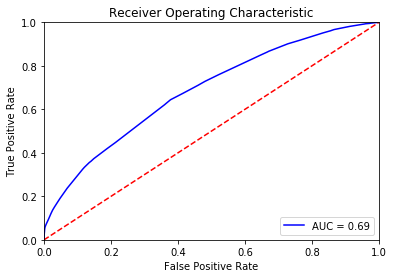

In [501]:
#fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [502]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

Best Threshold: 0.283 with G-Mean: 0.6331
FPR: 0.3777, TPR: 0.6441


In [241]:
y,class_names = pd.factorize(total_byidtarget_v2['fraude2'])

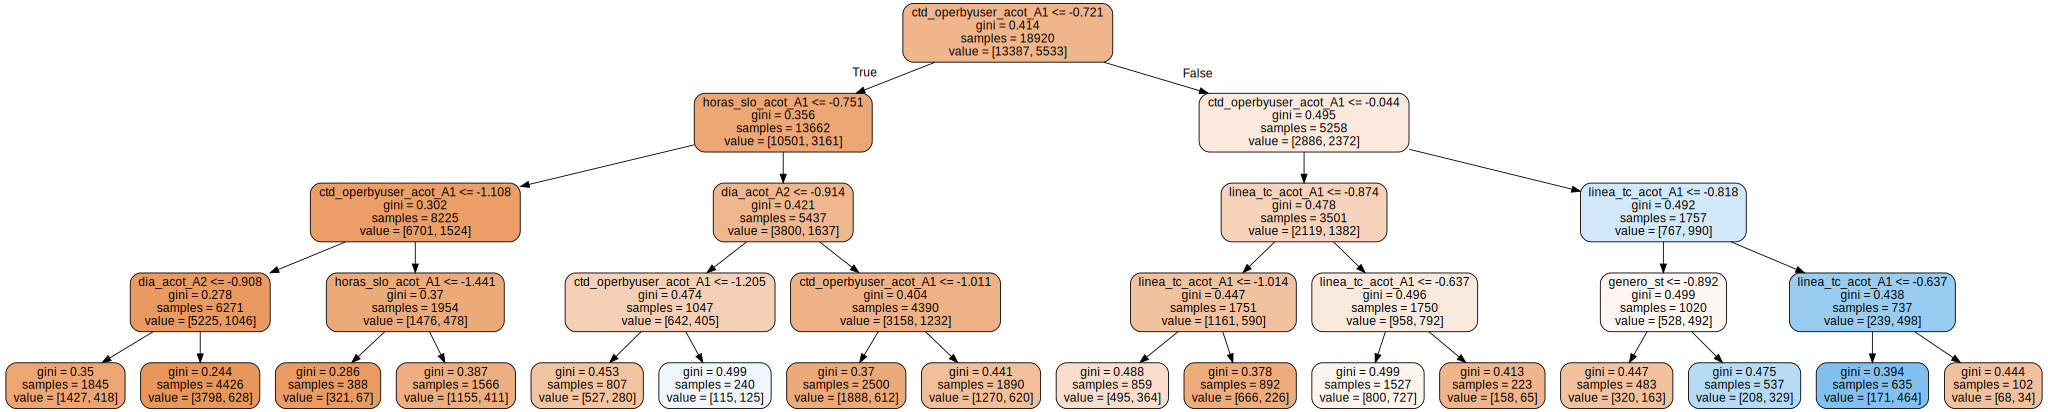

In [242]:

feature_names = var_finales
dot_data = tree.export_graphviz(gs.best_estimator_, out_file=None, filled=True, rounded = True, feature_names=feature_names)
graph = graphviz.Source(dot_data)
graph

In [334]:
probs = gs.best_estimator_.predict_proba(train_byidtarget_v2[var_finales])[:,1]
train_byidtarget_v2['PF']=probs
probs = gs.best_estimator_.predict_proba(test_byidtarget_v2[var_finales])[:,1]
test_byidtarget_v2['PF']=probs
probs = gs.best_estimator_.predict_proba(total_byidtarget_v2[var_finales])[:,1]
total_byidtarget_v2['PF']=probs

In [341]:
total_byidtarget_v2=total_byidtarget_v2.reset_index(drop=True)

In [385]:
newpf=[]
for a in range(len(total_byidtarget_v2)):
    if total_byidtarget_v2['PF'][a]==0:
        newpf.append(0.001)
    elif total_byidtarget_v2['PF'][a]==1:
        newpf.append(0.999)
    else:
        newpf.append(total_byidtarget_v2['PF'][a])
total_byidtarget_v2['PF_NEW']=newpf

In [386]:
newpf=[]
for a in range(len(train_byidtarget_v2)):
    if train_byidtarget_v2['PF'][a]==0:
        newpf.append(0.001)
    elif train_byidtarget_v2['PF'][a]==1:
        newpf.append(0.999)
    else:
        newpf.append(train_byidtarget_v2['PF'][a])
train_byidtarget_v2['PF_NEW']=newpf

In [387]:
newpf=[]
for a in range(len(test_byidtarget_v2)):
    if test_byidtarget_v2['PF'][a]==0:
        newpf.append(0.001)
    elif test_byidtarget_v2['PF'][a]==1:
        newpf.append(0.999)
    else:
        newpf.append(test_byidtarget_v2['PF'][a])
test_byidtarget_v2['PF_NEW']=newpf

In [635]:
path_modelo = 'Fraudster_dtv1.pickle'
pickle.dump(gs.best_estimator_, open(path_modelo, 'wb'))

# Calibrado de nivel

In [394]:
XB=-np.log((1/total_byidtarget_v2['PF_NEW'])-1)
total_byidtarget_v2['xb_pfnew']=XB
XB=-np.log((1/train_byidtarget_v2['PF_NEW'])-1)
train_byidtarget_v2['xb_pfnew']=XB
XB=-np.log((1/test_byidtarget_v2['PF_NEW'])-1)
test_byidtarget_v2['xb_pfnew']=XB

In [395]:

calibrada = LogisticRegression(random_state=123).fit(X=total_byidtarget_v2[['xb_pfnew']], y=total_byidtarget_v2['fraude2'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [412]:
train_byidtarget_v2['PF_CALIB']=calibrada.predict_proba(train_byidtarget_v2[['xb_pfnew']])[:,1]
test_byidtarget_v2['PF_CALIB']=calibrada.predict_proba(test_byidtarget_v2[['xb_pfnew']])[:,1]
total_byidtarget_v2['PF_CALIB']=calibrada.predict_proba(total_byidtarget_v2[['xb_pfnew']])[:,1]

# Analisis de resultados del modelo

In [431]:
dias=total_byidtarget_v2['dia'].unique()
dias.sort()
gini_target=[]
n_dia=[]
pf_dia=[]
rf_dia=[]
for a in dias:
    dates=total_byidtarget_v2.loc[total_byidtarget_v2['dia']==a]
    gini= 2*metrics.roc_auc_score(dates['fraude2'], dates['PD_CALIB'])-1
    gini_target.append(gini)
    n_dia.append(len(dates))
    pf_dia.append(dates['PF_CALIB'].mean())
    rf_dia.append(dates['fraude2'].mean())
    DISTRIBUCION=pd.DataFrame(list(zip(dias,gini_target,n_dia,
                                       pf_dia,rf_dia)),columns=['dia','gini_TARGET','n_dia','pf_dia','rf_dia'])
DISTRIBUCION

dia  gini_TARGET  n_dia    pf_dia    rf_dia
0     2     0.162574    940  0.268265  0.284043
1     3     0.211673    913  0.300728  0.305586
2     4     0.264696    899  0.329070  0.303671
3     5     0.358644    950  0.307513  0.301053
4     6     0.297931    933  0.232665  0.264737
5     7     0.277867    961  0.237285  0.284079
6     8     0.266059    919  0.244674  0.276387
7     9     0.357919    912  0.227588  0.290570
8    10     0.335910    869  0.231183  0.276180
9    11     0.316348    935  0.239470  0.278075
10   12     0.371868    969  0.241928  0.255934
11   13     0.420744    935  0.251111  0.294118
12   14     0.346499    884  0.259719  0.289593
13   15     0.343984    952  0.269428  0.304622
14   16     0.358627    916  0.267188  0.291485
15   17     0.379109    941  0.281865  0.282678
16   18     0.401618    936  0.301368  0.326923
17   19     0.404495    935  0.294231  0.283422
18   20     0.374838    927  0.299550  0.290183
19   21     0.443297    920  0.301449  0.296739
20   22     0.485629    928  0.315671  0.317888
21   23     0.429652    891  0.312383  0.295174
22   24     0.498082    966  0.319509  0.296066
23   25     0.443888    946  0.325073  0.265328
24   26     0.466434    926  0.332158  0.293737
25   27     0.437758    927  0.331820  0.249191
26   28     0.471219    914  0.335835  0.301969
27   29     0.476492    977  0.348083  0.279427
28   30     0.478995    954  0.364664  0.299790

## Distribucion del target y prediccion

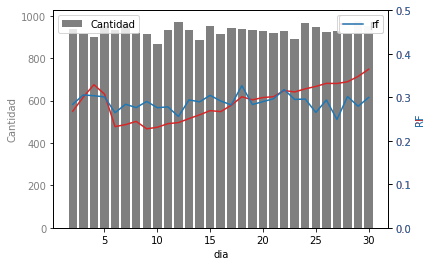

In [490]:
fig, ax1 = plt.subplots()

color = 'tab:gray'
ax1.set_xlabel('dia')
ax1.set_ylabel('Cantidad', color=color)
ax1.bar(DISTRIBUCION['dia'], DISTRIBUCION['n_dia'], color=color,label='Cantidad')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('PF', color=color)  # we already handled the x-label with ax1
ax2.plot(DISTRIBUCION['dia'], DISTRIBUCION['pf_dia'], color=color,label='pf')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,0.5])
ax2.legend()
ax3 = ax1.twinx()

color = 'tab:blue'
ax3.set_ylabel('RF', color=color)  # we already handled the x-label with ax1
ax3.plot(DISTRIBUCION['dia'], DISTRIBUCION['rf_dia'], color=color,label='rf')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim([0,0.5])
ax3.legend()
#fig.tight_layout() 

plt.show()

# Distribucion de las variables

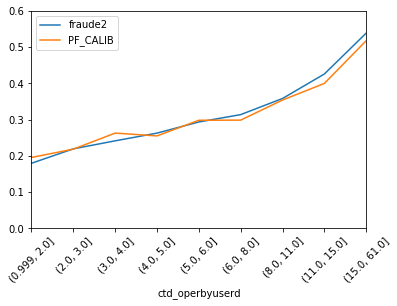

In [466]:
total_byidtarget_v2['ctd_operbyuserd']=pd.qcut(total_byidtarget_v2['ctd_operbyuser'], q=10,duplicates='drop')
dist_var=total_byidtarget_v2.groupby(['ctd_operbyuserd'],sort=True)['fraude2','PF_CALIB'].mean().reset_index()
dist_var.plot(x='ctd_operbyuserd',y=['fraude2','PF_CALIB'],kind='line',rot=45,ylim=([0,0.6]))

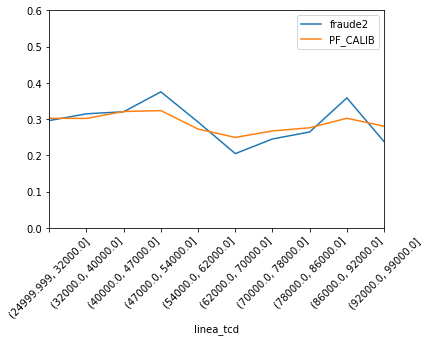

In [467]:
total_byidtarget_v2['linea_tcd']=pd.qcut(total_byidtarget_v2['linea_tc'], q=10,duplicates='drop')
dist_var=total_byidtarget_v2.groupby(['linea_tcd'],sort=True)['fraude2','PF_CALIB'].mean().reset_index()
dist_var.plot(x='linea_tcd',y=['fraude2','PF_CALIB'],kind='line',rot=45,ylim=([0,0.6]))

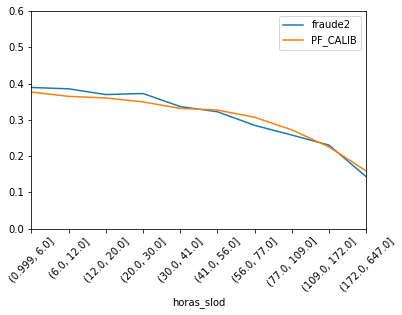

In [468]:
total_byidtarget_v2['horas_slod']=pd.qcut(total_byidtarget_v2['horas_slo'], q=10,duplicates='drop')
dist_var=total_byidtarget_v2.groupby(['horas_slod'],sort=True)['fraude2','PF_CALIB'].mean().reset_index()
dist_var.plot(x='horas_slod',y=['fraude2','PF_CALIB'],kind='line',rot=45,ylim=([0,0.6]))

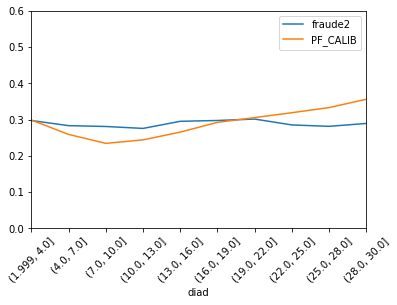

In [471]:
total_byidtarget_v2['diad']=pd.qcut(total_byidtarget_v2['dia'], q=10,duplicates='drop')
dist_var=total_byidtarget_v2.groupby(['diad'],sort=True)['fraude2','PF_CALIB'].mean().reset_index()
dist_var.plot(x='diad',y=['fraude2','PF_CALIB'],kind='line',rot=45,ylim=([0,0.6]))

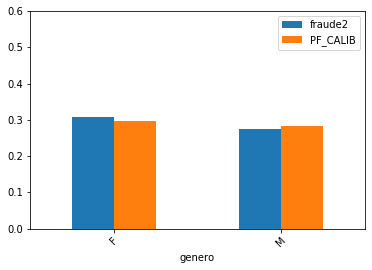

In [470]:
dist_var=total_byidtarget_v2.groupby(['genero'],sort=True)['fraude2','PF_CALIB'].mean().reset_index()
dist_var.plot(x='genero',y=['fraude2','PF_CALIB'],kind='bar',rot=45,ylim=([0,0.6]))

# Trade off modelo uso y no uso

In [503]:
tresh=0.283 #Punto de corte optimo
total_byidtarget_v2.loc[total_byidtarget_v2['PF_CALIB']>=tresh,'PRED_TRESH']=1
total_byidtarget_v2.loc[total_byidtarget_v2['PF_CALIB']<tresh,'PRED_TRESH']=0

Teniendo como contexto el uso o no uso del modelo, partamos por definir que todo aquella operacion que ha sido fraude tiene como perdida el monto de esa operacion y toda aquella operacion que no ha sido fraude tiene como ganancia el interes de esa operacion.

In [522]:
perdida0=total_byidtarget_v2.loc[(total_byidtarget_v2['fraude']==0)]['interes_tc'].sum()
ganancia0=total_byidtarget_v2.loc[(total_byidtarget_v2['fraude']==1)]['monto'].sum()

In [580]:
# Utilidad
ganancia0-perdida0

-863341.17

Ahora si se utilizase el modelo, habria que considerar como perdida el monto de aquellas operaciones que no fueron fraude, pero que el modelo (dado el punto de corte optimo) considera que si serian fraude en un futuro. Tambien son perdida el interes de aquellas operaciones que han sido fraude y el modelo no detecto que lo fueran asi.
Las ganancias, en cambio, son el monto de operaciones que fueron fraude y el modelo detecto que asi lo serian. Por ultimo el segundo tipo de ganancias serian aquellas operaciones que el modelo predijo que no serian fraude y efectivamente no lo fueron.

In [581]:
perdida1=total_byidtarget_v2.loc[(total_byidtarget_v2['fraude']==0)&(total_byidtarget_v2['PRED_TRESH']==1)]['interes_tc'].sum()
perdida2=total_byidtarget_v2.loc[(total_byidtarget_v2['fraude']==1)&(total_byidtarget_v2['PRED_TRESH']==0)]['monto'].sum()
ganancia1=total_byidtarget_v2.loc[(total_byidtarget_v2['fraude']==1)&(total_byidtarget_v2['PRED_TRESH']==1)]['monto'].sum()
ganancia2=total_byidtarget_v2.loc[(total_byidtarget_v2['fraude']==0)&(total_byidtarget_v2['PRED_TRESH']==0)]['interes_tc'].sum()

In [582]:
# Utilidad
(ganancia2+ganancia1)-(perdida1+perdida2)

104258.72999999998

Debido a que no se tiene un diccionario, vamos a tomar un supuesto respecto a la variables 'status_txn', la cual se asume que es el status de la transaccion. Con ello las formulas anteriores propuestas cambian tomando en cuenta si la operacion se encuentra aceptada, rechazada o en proceso.

Vamos a excluir del analisis las operaciones 'en proceso'.

**Se pueden rechazar a clientes por multiples motivos no necesariamente asociados al fraude. Vamos a simplificar el analisis y asumir que todos los clientes rechazados han sido porque se creia que harian fraude**

In [589]:
analisis1 = total_byidtarget_v2.loc[total_byidtarget_v2['status_txn']!='En proceso']

In [593]:
perdida3=analisis1.loc[(analisis1['fraude']==1)&(analisis1['status_txn']=='Aceptada')]['monto'].sum()
perdida4=analisis1.loc[(analisis1['fraude']==0)&(analisis1['status_txn']=='Rechazada')]['interes_tc'].sum()
ganancia3=analisis1.loc[(analisis1['fraude']==0)&(analisis1['status_txn']=='Aceptada')]['interes_tc'].sum()
ganancia4=analisis1.loc[(analisis1['fraude']==1)&(analisis1['status_txn']=='Rechazada')]['monto'].sum()

In [594]:
# Utilidad normal
(ganancia3+ganancia4)-(perdida3+perdida4) 

513529.5800000001

In [596]:
perdida1=analisis1.loc[(analisis1['fraude']==0)&(analisis1['PRED_TRESH']==1)]['interes_tc'].sum()
perdida2=analisis1.loc[(analisis1['fraude']==1)&(analisis1['PRED_TRESH']==0)]['monto'].sum()
ganancia1=analisis1.loc[(analisis1['fraude']==1)&(analisis1['PRED_TRESH']==1)]['monto'].sum()
ganancia2=analisis1.loc[(analisis1['fraude']==0)&(analisis1['PRED_TRESH']==0)]['interes_tc'].sum()

In [597]:
# Utilidad del modelo
(ganancia2+ganancia1)-(perdida1+perdida2)

93933.88

Se observa que el modelo, performa peor que una clasificacion simple acerca de la transaccion. Esto es debido a que, en primera instancia, el que la operacion haga fraude o no, no es el target del modelo. El target del modelo es detectar si el cliente hara fraude en un futuro (*mayor explicacion en la guia metodologica*). Si buscamos la deteccion de clientes que haran fraude y lo llevamos eso al analisis podemos hacer una comparacion mas justa para este.

Como ultimo punto, las operaciones que no han sido fraude, pero que el cliente tendra un futuro fraude con una operacion diferente, no se considerara como perdida o ganancia el monto de la operacion, sino mas bien los intereses (no se busca tener clientes en el portafolio que cometan fraude).

In [615]:
perdida3=analisis1.loc[(analisis1['fraude']==1)&(analisis1['status_txn']=='Aceptada')]['monto'].sum()
perdida4=analisis1.loc[(analisis1['fraude']==0)&(analisis1['fraude2']==1)
                       &(analisis1['status_txn']=='Aceptada')]['interes_tc'].sum()
perdida5=analisis1.loc[(analisis1['fraude2']==0)&(analisis1['status_txn']=='Rechazada')]['interes_tc'].sum()
ganancia3=analisis1.loc[(analisis1['fraude2']==0)&(analisis1['status_txn']=='Aceptada')]['interes_tc'].sum()
ganancia4=analisis1.loc[(analisis1['fraude']==1)&(analisis1['status_txn']=='Rechazada')]['monto'].sum()
ganancia5=analisis1.loc[(analisis1['fraude']==0)&(analisis1['fraude2']==1)
                        &(analisis1['status_txn']=='Rechazada')]['interes_tc'].sum()

In [616]:
# Utilidad normal
(ganancia3+ganancia4+ganancia5)-(perdida3+perdida4+perdida5) 

109447.58000000007

In [617]:
perdida3=analisis1.loc[(analisis1['fraude']==1)&(analisis1['PRED_TRESH']==0)]['monto'].sum()
perdida4=analisis1.loc[(analisis1['fraude']==0)&(analisis1['fraude2']==1)
                       &(analisis1['PRED_TRESH']==0)]['interes_tc'].sum()
perdida5=analisis1.loc[(analisis1['fraude2']==0)&(analisis1['PRED_TRESH']==1)]['interes_tc'].sum()
ganancia3=analisis1.loc[(analisis1['fraude2']==0)&(analisis1['PRED_TRESH']==0)]['interes_tc'].sum()
ganancia4=analisis1.loc[(analisis1['fraude']==1)&(analisis1['PRED_TRESH']==1)]['monto'].sum()
ganancia5=analisis1.loc[(analisis1['fraude']==0)&(analisis1['fraude2']==1)
                        &(analisis1['PRED_TRESH']==1)]['interes_tc'].sum()

In [618]:
# Utilidad normal
(ganancia3+ganancia4+ganancia5)-(perdida3+perdida4+perdida5) 

272319.88

El modelo presenta mejor discriminacion en utilidad tomando los supuestos considerados anteriormente.

# Anexos

### 1. Categorizacion de clientes y descripcion de estos

In [531]:
# Cantidad de clientes en el mes
len(total_byidtarget_v2['ID_USER'].unique())

4000

In [546]:
dif_clidia=[]
dia=[]
for a in range(3,31):
    list_rep=list(total_byidtarget_v2.loc[total_byidtarget_v2['dia']<a]['ID_USER'].unique())
    list_dia=list(total_byidtarget_v2.loc[total_byidtarget_v2['dia']==a]['ID_USER'].unique())
    dif_clidia.append(len(set(list_dia) - set(list_rep)))
    dia.append(a)

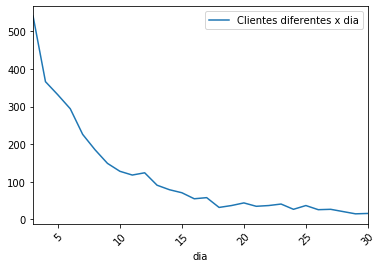

In [550]:
# Conocer cuantos clientes nuevos llegan por dia
pd.DataFrame(list(zip(dia,dif_clidia)),
             columns=['dia','Clientes diferentes x dia']).plot(x='dia',
                                                               y='Clientes diferentes x dia',
                                                               kind='line',
                                                               rot=45)

Los clientes nuevos tienden a rondar en los primeros dias del mes.

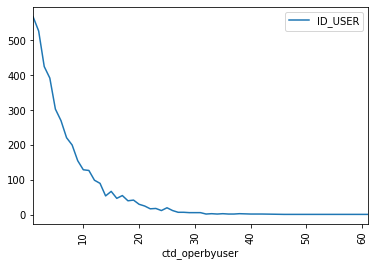

In [567]:
# Conocer cuantas operaciones tiene un cliente en el mes
cantidad_oper=total_byidtarget_v2.groupby(['ID_USER'],sort=True)[['ctd_operbyuser']].max().reset_index()
cantidad_oper.groupby(['ctd_operbyuser'],sort=True).count().reset_index().plot(x='ctd_operbyuser',
                                                                               y='ID_USER',
                                                                               kind='line',
                                                                               rot=90)

El 80% de los clientes hacen menos de 10 operaciones por mes y un 15% solo hace una operacion en el mes.

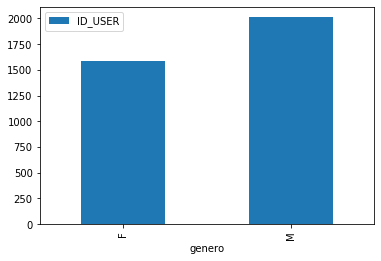

In [576]:
# Conocer la distribucione de hombres y mujeres por cliente
genero_cli=total_byidtarget_v2[['ID_USER','genero']].drop_duplicates(subset=["ID_USER", "genero"])
genero_cli.groupby(['genero'],sort=True).count().reset_index().plot(x='genero',
                                                                               y='ID_USER',
                                                                               kind='bar')

### 2. Si no se splitea por cliente el modelo tenderia a overfitear, se puede observar que el performance en test, es incluso mejor que el performance en train, esto se da debido a que las observaciones no son del todo independientes entre si.

In [249]:
total_byidtarget_v2 = pd.concat([train_byidtarget_v2,test_byidtarget_v2])

In [250]:
trainprueba, testprueba = train_test_split(total_byidtarget_v2,test_size=0.30,random_state=123,
                                           stratify=total_byidtarget_v2['fraude2'])

In [251]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
model = LogisticRegression(random_state= 123, solver='lbfgs', max_iter=5000,penalty='l2')

grid = {"C": [0.001, 0.01,0.1,0.5,1],
       'class_weight': ['balanced',{True:0.5,False:0.5}]}

gs = GridSearchCV(model, param_grid = grid, cv = kfold, return_train_score=True, scoring = 'recall',verbose = 2)
gs.fit(trainprueba[var_finales],trainprueba['fraude2'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight=balanced ..................................
[CV] ................... C=0.001, class_weight=balanced, total=   0.0s
[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.001, class_weight={True: 0.5, False: 0.5}, total=   0.0s
[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.00

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.001, class_weight={True: 0.5, False: 0.5}, total=   0.0s
[CV] C=0.001, class_weight={True: 0.5, False: 0.5} ...................
[CV] .... C=0.001, class_weight={True: 0.5, False: 0.5}, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] C=0.01, class_weight=balanced ...................................
[CV] .................... C=0.01, class_weight=balanced, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=5000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'class_weight': ['balanced', {False: 0.5, True: 0.5}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=2)

In [252]:
gs.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [253]:
#gini train
probs = gs.best_estimator_.predict_proba(trainprueba[var_finales])
gini = 2*metrics.roc_auc_score(trainprueba['fraude2'], probs[:,1])-1
gini

0.3203005088514015

In [254]:
#gini test
probs = gs.best_estimator_.predict_proba(testprueba[var_finales])
gini = 2*metrics.roc_auc_score(testprueba['fraude2'], probs[:,1])-1
gini

0.3624971479406831

In [255]:
model = DecisionTreeClassifier(random_state = 123)
max_depth=5
min_sample_split=12
grid = {"max_depth": [max_depth-1, max_depth, max_depth+1],
        "max_features": ['auto', 'log2'],
        "min_samples_split": [min_sample_split-2, min_sample_split, min_sample_split+2],
        "min_samples_leaf": [5, 6, 7],
        "criterion": ["gini", 'entropy'],
        'class_weight': ['balanced',None],
        'max_features': [0.6,0.8,1]
        }            
gs = GridSearchCV(model, param_grid = grid, cv = kfold, n_jobs=-1, return_train_score=True, scoring = 'roc_auc',verbose=2)
gs.fit(trainprueba[var_finales],trainprueba['fraude2'])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    6.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
       

In [256]:
gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [257]:
#gini train
probs = gs.best_estimator_.predict_proba(trainprueba[var_finales])
gini = 2*metrics.roc_auc_score(trainprueba['fraude2'], probs[:,1])-1
gini

0.3797150244266805

In [258]:
#gini test
probs = gs.best_estimator_.predict_proba(testprueba[var_finales])
gini = 2*metrics.roc_auc_score(testprueba['fraude2'], probs[:,1])-1
gini

0.3492565322377461